In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
boston = load_boston(return_X_y=False)
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=50)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)

X_train_mean = X_train.mean(0)
X_train_std = X_train.std(0)
X_train_norm = X_train.add(-1, X_train_mean) / X_train_std


y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)
y_train_norm = y_train.add(-1, y_train_mean) / y_train_std

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).view(-1,1)

# X_test_mean = X_test.mean(0)
# X_test_std = X_test.std(0)
# X_test_norm = X_test.add(-1, X_test_mean) / X_test_std


# y_test_mean = y_test.mean(0)
# y_test_std = y_test.std(0)
# y_test_norm = y_test.add(-1, y_test_mean) / y_test_std

In [3]:
train_data = torch.utils.data.TensorDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(13, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [5]:
def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max

def test(Y_true, K_test, means, logvar):
    """
    Estimate predictive log likelihood:
    log p(y|x, D) = log int p(y|x, w) p(w|D) dw
                 ~= log int p(y|x, w) q(w) dw
                 ~= log 1/K sum p(y|x, w_k) with w_k sim q(w)
                  = LogSumExp log p(y|x, w_k) - log K
    :Y_true: a 2D array of size N x dim
    :MC_samples: a 3D array of size samples K x N x 2*D
    """
    k = K_test
    N = Y_true.shape[0]
    mean = means 
    logvar = logvar
    test_ll = -0.5 * np.exp(-logvar) * (mean - Y_val.squeeze())**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi) #Y_true[None]
    test_ll = np.sum(np.sum(test_ll, -1), -1)
    test_ll = logsumexp(test_ll) - np.log(k)
    pppp = test_ll / N  # per point predictive probability
    rmse = np.mean((np.mean(mean, 0) - Y_val.squeeze())**2.)**0.5
    return pppp, rmse

In [5]:
class evaluation(object):
    def __init__(self, test_data, std_true, X_mean=None, X_std=None, y_mean=None, y_std=None):
        self.test_data = test_data
        self.std_true = std_true
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.n = 0
        self.avg_prediction = 0.
        self.sum_pp = 0.
        self.sumsqr_pp = 0.
        self.preds = torch.zeros(len(test_data.dataset),14000)

    def fn(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)

                if (self.X_mean is not None) & (self.X_std is not None):
                    x = (x - self.X_mean).float() / self.X_std

                standard_pred = model(x)

                if (self.y_mean is not None) & (self.y_std is not None):
                    standard_pred = standard_pred * self.y_std + self.y_mean
                
                self.preds[:,self.n-1] = standard_pred.view(-1,)
#                avg_pred = torch.mean(self.preds[:,:(self.n+1)].view(-1,self.n+1),1)
#                std_pred = torch.std(self.preds[:,:(self.n+1)].view(-1,self.n+1),1)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + standard_pred.view(-1,1) / self.n
#                std_pred = torch.std(y - self.avg_prediction)
                self.sum_pp += standard_pred
                self.sumsqr_pp += standard_pred * standard_pred
                std_pred = torch.sqrt((self.sumsqr_pp - (self.sum_pp * self.sum_pp) / self.n) / (self.n - 1))



                norm = torch.distributions.normal.Normal(y, std_pred)
                test_ll = norm.log_prob(self.avg_prediction).mean()



                error = nn.MSELoss(size_average=True)
                rmse = error(self.avg_prediction, y) ** 0.5
#                 test_ll = -0.5 * np.exp(-logvar) * (mean - Y_val.squeeze())**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi) #Y_true[None]
#                 test_ll = np.sum(np.sum(test_ll, -1), -1)
#                 test_ll = logsumexp(test_ll) - np.log(k)
#                 pppp = test_ll / N  # per point predictive probability
#                 rmse = np.mean((np.mean(mean, 0) - Y_val.squeeze())**2.)**0.5

                return rmse, test_ll, self.preds

In [7]:
def gelman_rubin(x, return_var=False):
    m, n = x.size()

    var_between = torch.sum((torch.mean(x, 1) - torch.mean(x)) ** 2) / (m - 1)
    x_bar = torch.mean(x, 1).view(-1,1)

    var_within = torch.sum((x - x_bar) ** 2) / (m * (n - 1))

    var = var_within * (n - 1) / n + var_between

    if return_var:
        return var

    V = var_within + var_between / n

    return torch.sqrt(V / var_within)

def ess(x):
    m, n = x.size()
    
    s_sq = gelman_rubin(x, return_var = True)
    
    neg_autocorr = False
    t = 1
    
    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t]) ** 2 for i in range(t,n)) for j in range(m)) / (m * (n - t)))
    
    rho = torch.ones(n)
    
    while not neg_autocorr and (t < n):
        rho[t] = 1. - variogram(t) / (2. * s_sq)
        
        if not t % 2:
            neg_autocorr = sum(rho[(t-1):(t+1)]) < 0
        t += 1
        
    return float(m * n)/ (1. + 2. * rho[1:t].sum())

In [10]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-5
#3e-2



batch_size = 32.
dataset_size= 456.

network = Model()
criterion = nn.MSELoss(size_average=False)

optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)

evaluate = evaluation(test_loader, 4.5, X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_sgld = []
test_rmse = []
log_lik_sgld = []
t = 1.

for epoch in range(10000):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        network.zero_grad()
        output = network(x)
        loss = 0.5 * criterion(output, y)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 1000) & (t % 100 == 0):
            rmse, log_lik, predictions = evaluate.fn(network)

#                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
            test_rmse.append(rmse)
            log_lik_sgld.append(log_lik)
        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 17.5879
Epoch 1 - loss: 11.6886
Epoch 2 - loss: 9.2071
Epoch 3 - loss: 8.0989
Epoch 4 - loss: 7.3791
Epoch 5 - loss: 6.8053
Epoch 6 - loss: 6.5306
Epoch 7 - loss: 6.0145
Epoch 8 - loss: 5.8396
Epoch 9 - loss: 5.7867
Epoch 10 - loss: 5.4909
Epoch 11 - loss: 5.2677
Epoch 12 - loss: 5.3051
Epoch 13 - loss: 5.2087
Epoch 14 - loss: 5.0555
Epoch 15 - loss: 5.0739
Epoch 16 - loss: 5.0217
Epoch 17 - loss: 4.9891
Epoch 18 - loss: 4.9119
Epoch 19 - loss: 4.8602
Epoch 20 - loss: 4.8480
Epoch 21 - loss: 4.7311
Epoch 22 - loss: 4.6319
Epoch 23 - loss: 4.5933
Epoch 24 - loss: 4.5647
Epoch 25 - loss: 4.6634
Epoch 26 - loss: 4.5418
Epoch 27 - loss: 4.4812
Epoch 28 - loss: 4.3932
Epoch 29 - loss: 4.4594
Epoch 30 - loss: 4.3003
Epoch 31 - loss: 4.2742
Epoch 32 - loss: 4.3031
Epoch 33 - loss: 4.3087
Epoch 34 - loss: 4.3192
Epoch 35 - loss: 4.3585
Epoch 36 - loss: 4.3938
Epoch 37 - loss: 4.2780
Epoch 38 - loss: 4.2337
Epoch 39 - loss: 4.0973
Epoch 40 - loss: 4.1623
Epoch 41 - loss: 4.1500


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Epoch 68 - loss: 3.7883
Epoch 69 - loss: 3.7328
Epoch 70 - loss: 3.7678
Epoch 71 - loss: 3.8479
Epoch 72 - loss: 3.6495
Epoch 73 - loss: 3.6014
Epoch 74 - loss: 3.5895
Epoch 75 - loss: 3.4238
Epoch 76 - loss: 3.3316
Epoch 77 - loss: 3.2326
Epoch 78 - loss: 3.2722
Epoch 79 - loss: 3.2605
Epoch 80 - loss: 3.2454
Epoch 81 - loss: 3.2648
Epoch 82 - loss: 3.1739
Epoch 83 - loss: 3.0648
Epoch 84 - loss: 3.0632
Epoch 85 - loss: 3.2270
Epoch 86 - loss: 3.1107
Epoch 87 - loss: 3.2302
Epoch 88 - loss: 3.0848
Epoch 89 - loss: 3.0380
Epoch 90 - loss: 3.0449
Epoch 91 - loss: 2.9325
Epoch 92 - loss: 2.9192
Epoch 93 - loss: 2.8566
Epoch 94 - loss: 3.0881
Epoch 95 - loss: 2.9836
Epoch 96 - loss: 3.0876
Epoch 97 - loss: 3.0520
Epoch 98 - loss: 3.1067
Epoch 99 - loss: 2.9543
Epoch 100 - loss: 2.9330
Epoch 101 - loss: 2.9028
Epoch 102 - loss: 2.7987
Epoch 103 - loss: 2.7465
Epoch 104 - loss: 2.6791
Epoch 105 - loss: 2.7013
Epoch 106 - loss: 2.6463
Epoch 107 - loss: 2.7120
Epoch 108 - loss: 2.6959
Epoch 1

Epoch 401 - loss: 2.7907
Epoch 402 - loss: 2.7777
Epoch 403 - loss: 2.8649
Epoch 404 - loss: 3.0352
Epoch 405 - loss: 2.8397
Epoch 406 - loss: 3.1022
Epoch 407 - loss: 2.8918
Epoch 408 - loss: 2.7219
Epoch 409 - loss: 2.6846
Epoch 410 - loss: 2.6852
Epoch 411 - loss: 2.8993
Epoch 412 - loss: 2.9598
Epoch 413 - loss: 2.6855
Epoch 414 - loss: 2.7348
Epoch 415 - loss: 2.8690
Epoch 416 - loss: 2.8254
Epoch 417 - loss: 2.5987
Epoch 418 - loss: 2.7020
Epoch 419 - loss: 2.6483
Epoch 420 - loss: 2.8094
Epoch 421 - loss: 2.8043
Epoch 422 - loss: 2.6861
Epoch 423 - loss: 3.0291
Epoch 424 - loss: 2.9322
Epoch 425 - loss: 2.8021
Epoch 426 - loss: 2.7647
Epoch 427 - loss: 2.6489
Epoch 428 - loss: 2.5220
Epoch 429 - loss: 2.5080
Epoch 430 - loss: 2.5322
Epoch 431 - loss: 2.6143
Epoch 432 - loss: 2.7075
Epoch 433 - loss: 2.7637
Epoch 434 - loss: 2.7965
Epoch 435 - loss: 2.9374
Epoch 436 - loss: 2.7746
Epoch 437 - loss: 2.8980
Epoch 438 - loss: 2.5774
Epoch 439 - loss: 2.7175
Epoch 440 - loss: 2.7777


Epoch 731 - loss: 2.9692
Epoch 732 - loss: 2.9503
Epoch 733 - loss: 2.9337
Epoch 734 - loss: 2.8302
Epoch 735 - loss: 2.8818
Epoch 736 - loss: 2.9227
Epoch 737 - loss: 2.9562
Epoch 738 - loss: 3.0387
Epoch 739 - loss: 2.7410
Epoch 740 - loss: 2.7113
Epoch 741 - loss: 2.9623
Epoch 742 - loss: 2.8323
Epoch 743 - loss: 2.8214
Epoch 744 - loss: 3.0343
Epoch 745 - loss: 2.9545
Epoch 746 - loss: 2.8788
Epoch 747 - loss: 2.6767
Epoch 748 - loss: 2.8055
Epoch 749 - loss: 2.7986
Epoch 750 - loss: 2.7178
Epoch 751 - loss: 2.9688
Epoch 752 - loss: 2.8219
Epoch 753 - loss: 2.8424
Epoch 754 - loss: 2.9950
Epoch 755 - loss: 2.6715
Epoch 756 - loss: 2.6426
Epoch 757 - loss: 2.6290
Epoch 758 - loss: 3.1695
Epoch 759 - loss: 2.8075
Epoch 760 - loss: 2.8490
Epoch 761 - loss: 2.6891
Epoch 762 - loss: 2.8282
Epoch 763 - loss: 2.5235
Epoch 764 - loss: 2.8379
Epoch 765 - loss: 2.6094
Epoch 766 - loss: 2.4021
Epoch 767 - loss: 2.6834
Epoch 768 - loss: 2.4414
Epoch 769 - loss: 2.6353
Epoch 770 - loss: 2.5391


Epoch 1058 - loss: 2.7736
Epoch 1059 - loss: 2.8245
Epoch 1060 - loss: 3.0563
Epoch 1061 - loss: 2.8946
Epoch 1062 - loss: 2.8403
Epoch 1063 - loss: 2.7167
Epoch 1064 - loss: 2.5584
Epoch 1065 - loss: 2.8629
Epoch 1066 - loss: 2.9165
Epoch 1067 - loss: 3.0175
Epoch 1068 - loss: 3.0861
Epoch 1069 - loss: 2.8764
Epoch 1070 - loss: 2.9623
Epoch 1071 - loss: 2.7623
Epoch 1072 - loss: 2.9231
Epoch 1073 - loss: 3.0896
Epoch 1074 - loss: 3.2235
Epoch 1075 - loss: 3.3647
Epoch 1076 - loss: 3.3631
Epoch 1077 - loss: 3.1065
Epoch 1078 - loss: 3.3705
Epoch 1079 - loss: 3.1098
Epoch 1080 - loss: 2.9872
Epoch 1081 - loss: 2.8349
Epoch 1082 - loss: 3.0606
Epoch 1083 - loss: 2.9309
Epoch 1084 - loss: 2.8630
Epoch 1085 - loss: 3.3656
Epoch 1086 - loss: 3.5681
Epoch 1087 - loss: 3.3860
Epoch 1088 - loss: 3.2896
Epoch 1089 - loss: 3.4104
Epoch 1090 - loss: 3.4565
Epoch 1091 - loss: 3.1865
Epoch 1092 - loss: 3.0878
Epoch 1093 - loss: 2.9456
Epoch 1094 - loss: 3.3998
Epoch 1095 - loss: 3.7722
Epoch 1096 -

Epoch 1376 - loss: 7.8395
Epoch 1377 - loss: 5.4616
Epoch 1378 - loss: 3.4479
Epoch 1379 - loss: 4.3047
Epoch 1380 - loss: 6.0528
Epoch 1381 - loss: 3.5121
Epoch 1382 - loss: 4.4211
Epoch 1383 - loss: 3.1242
Epoch 1384 - loss: 6.0015
Epoch 1385 - loss: 3.6154
Epoch 1386 - loss: 3.9313
Epoch 1387 - loss: 6.7233
Epoch 1388 - loss: 7.1970
Epoch 1389 - loss: 3.7755
Epoch 1390 - loss: 7.6918
Epoch 1391 - loss: 3.8438
Epoch 1392 - loss: 3.9836
Epoch 1393 - loss: 3.0808
Epoch 1394 - loss: 4.0219
Epoch 1395 - loss: 3.5128
Epoch 1396 - loss: 3.7429
Epoch 1397 - loss: 5.2572
Epoch 1398 - loss: 3.5313
Epoch 1399 - loss: 3.4377
Epoch 1400 - loss: 3.6713
Epoch 1401 - loss: 3.5071
Epoch 1402 - loss: 3.7292
Epoch 1403 - loss: 3.7886
Epoch 1404 - loss: 3.7062
Epoch 1405 - loss: 3.6849
Epoch 1406 - loss: 3.1447
Epoch 1407 - loss: 3.5048
Epoch 1408 - loss: 3.3021
Epoch 1409 - loss: 3.3847
Epoch 1410 - loss: 2.9826
Epoch 1411 - loss: 2.9068
Epoch 1412 - loss: 2.9872
Epoch 1413 - loss: 2.9881
Epoch 1414 -

Epoch 1696 - loss: 3.3938
Epoch 1697 - loss: 3.6213
Epoch 1698 - loss: 3.3733
Epoch 1699 - loss: 3.6202
Epoch 1700 - loss: 3.0565
Epoch 1701 - loss: 3.4685
Epoch 1702 - loss: 3.2832
Epoch 1703 - loss: 4.0449
Epoch 1704 - loss: 3.8313
Epoch 1705 - loss: 5.0710
Epoch 1706 - loss: 3.8708
Epoch 1707 - loss: 3.8273
Epoch 1708 - loss: 4.2248
Epoch 1709 - loss: 3.8444
Epoch 1710 - loss: 4.0724
Epoch 1711 - loss: 4.3896
Epoch 1712 - loss: 4.4875
Epoch 1713 - loss: 4.1198
Epoch 1714 - loss: 3.2173
Epoch 1715 - loss: 2.9001
Epoch 1716 - loss: 3.3920
Epoch 1717 - loss: 3.0012
Epoch 1718 - loss: 3.6539
Epoch 1719 - loss: 3.5429
Epoch 1720 - loss: 3.5196
Epoch 1721 - loss: 4.8390
Epoch 1722 - loss: 4.2566
Epoch 1723 - loss: 4.5318
Epoch 1724 - loss: 3.4253
Epoch 1725 - loss: 5.2255
Epoch 1726 - loss: 3.4792
Epoch 1727 - loss: 3.5803
Epoch 1728 - loss: 3.2918
Epoch 1729 - loss: 3.2744
Epoch 1730 - loss: 6.3567
Epoch 1731 - loss: 4.4557
Epoch 1732 - loss: 3.7476
Epoch 1733 - loss: 4.1982
Epoch 1734 -

Epoch 2014 - loss: 3.3567
Epoch 2015 - loss: 4.1724
Epoch 2016 - loss: 4.2447
Epoch 2017 - loss: 3.1610
Epoch 2018 - loss: 3.7143
Epoch 2019 - loss: 3.9381
Epoch 2020 - loss: 3.7521
Epoch 2021 - loss: 3.1250
Epoch 2022 - loss: 3.8868
Epoch 2023 - loss: 3.4803
Epoch 2024 - loss: 3.3015
Epoch 2025 - loss: 3.2239
Epoch 2026 - loss: 3.6318
Epoch 2027 - loss: 3.6789
Epoch 2028 - loss: 3.7127
Epoch 2029 - loss: 3.4847
Epoch 2030 - loss: 3.7659
Epoch 2031 - loss: 3.9607
Epoch 2032 - loss: 3.5193
Epoch 2033 - loss: 3.2115
Epoch 2034 - loss: 3.0065
Epoch 2035 - loss: 3.4030
Epoch 2036 - loss: 4.2663
Epoch 2037 - loss: 4.6709
Epoch 2038 - loss: 3.5315
Epoch 2039 - loss: 4.0180
Epoch 2040 - loss: 3.4236
Epoch 2041 - loss: 4.8783
Epoch 2042 - loss: 4.5061
Epoch 2043 - loss: 3.3124
Epoch 2044 - loss: 3.1438
Epoch 2045 - loss: 3.4671
Epoch 2046 - loss: 3.9630
Epoch 2047 - loss: 3.8311
Epoch 2048 - loss: 3.3255
Epoch 2049 - loss: 2.9564
Epoch 2050 - loss: 4.2543
Epoch 2051 - loss: 3.0180
Epoch 2052 -

Epoch 2332 - loss: 5.2153
Epoch 2333 - loss: 4.2050
Epoch 2334 - loss: 4.8175
Epoch 2335 - loss: 4.1357
Epoch 2336 - loss: 3.8908
Epoch 2337 - loss: 3.7669
Epoch 2338 - loss: 3.6912
Epoch 2339 - loss: 3.0744
Epoch 2340 - loss: 4.0513
Epoch 2341 - loss: 4.0261
Epoch 2342 - loss: 4.6246
Epoch 2343 - loss: 4.0618
Epoch 2344 - loss: 3.6474
Epoch 2345 - loss: 3.7905
Epoch 2346 - loss: 3.4745
Epoch 2347 - loss: 4.4963
Epoch 2348 - loss: 4.4778
Epoch 2349 - loss: 4.0827
Epoch 2350 - loss: 4.1676
Epoch 2351 - loss: 4.5526
Epoch 2352 - loss: 4.8230
Epoch 2353 - loss: 3.9998
Epoch 2354 - loss: 5.3336
Epoch 2355 - loss: 5.0440
Epoch 2356 - loss: 3.7040
Epoch 2357 - loss: 4.3908
Epoch 2358 - loss: 3.7642
Epoch 2359 - loss: 4.7873
Epoch 2360 - loss: 4.5601
Epoch 2361 - loss: 6.1893
Epoch 2362 - loss: 4.1946
Epoch 2363 - loss: 3.7954
Epoch 2364 - loss: 4.6807
Epoch 2365 - loss: 3.0017
Epoch 2366 - loss: 3.4887
Epoch 2367 - loss: 3.4457
Epoch 2368 - loss: 3.4784
Epoch 2369 - loss: 3.6630
Epoch 2370 -

Epoch 2650 - loss: 3.0251
Epoch 2651 - loss: 3.2788
Epoch 2652 - loss: 3.0201
Epoch 2653 - loss: 2.9152
Epoch 2654 - loss: 2.8953
Epoch 2655 - loss: 2.8484
Epoch 2656 - loss: 2.8434
Epoch 2657 - loss: 3.8582
Epoch 2658 - loss: 3.0927
Epoch 2659 - loss: 2.9586
Epoch 2660 - loss: 3.8888
Epoch 2661 - loss: 3.0558
Epoch 2662 - loss: 3.5960
Epoch 2663 - loss: 3.5752
Epoch 2664 - loss: 3.5301
Epoch 2665 - loss: 4.0837
Epoch 2666 - loss: 3.0676
Epoch 2667 - loss: 3.4567
Epoch 2668 - loss: 3.5969
Epoch 2669 - loss: 3.6300
Epoch 2670 - loss: 3.7081
Epoch 2671 - loss: 4.1263
Epoch 2672 - loss: 3.6063
Epoch 2673 - loss: 2.8666
Epoch 2674 - loss: 3.1892
Epoch 2675 - loss: 3.5696
Epoch 2676 - loss: 3.1097
Epoch 2677 - loss: 3.0811
Epoch 2678 - loss: 3.2054
Epoch 2679 - loss: 3.4727
Epoch 2680 - loss: 5.8912
Epoch 2681 - loss: 5.6326
Epoch 2682 - loss: 4.4453
Epoch 2683 - loss: 4.9311
Epoch 2684 - loss: 4.9075
Epoch 2685 - loss: 4.1647
Epoch 2686 - loss: 4.3382
Epoch 2687 - loss: 3.7180
Epoch 2688 -

Epoch 2968 - loss: 4.2333
Epoch 2969 - loss: 3.1011
Epoch 2970 - loss: 2.8514
Epoch 2971 - loss: 2.7983
Epoch 2972 - loss: 2.8819
Epoch 2973 - loss: 3.0294
Epoch 2974 - loss: 4.3550
Epoch 2975 - loss: 3.5904
Epoch 2976 - loss: 2.9385
Epoch 2977 - loss: 2.9612
Epoch 2978 - loss: 4.0916
Epoch 2979 - loss: 3.9102
Epoch 2980 - loss: 3.2519
Epoch 2981 - loss: 4.2249
Epoch 2982 - loss: 2.7969
Epoch 2983 - loss: 4.7107
Epoch 2984 - loss: 4.3664
Epoch 2985 - loss: 6.3393
Epoch 2986 - loss: 2.9613
Epoch 2987 - loss: 2.7739
Epoch 2988 - loss: 3.4835
Epoch 2989 - loss: 3.3238
Epoch 2990 - loss: 3.2552
Epoch 2991 - loss: 6.6512
Epoch 2992 - loss: 7.7251
Epoch 2993 - loss: 5.0209
Epoch 2994 - loss: 6.4157
Epoch 2995 - loss: 3.2343
Epoch 2996 - loss: 3.8806
Epoch 2997 - loss: 3.1977
Epoch 2998 - loss: 2.8417
Epoch 2999 - loss: 3.0423
Epoch 3000 - loss: 3.0779
Epoch 3001 - loss: 3.6498
Epoch 3002 - loss: 3.4486
Epoch 3003 - loss: 3.4395
Epoch 3004 - loss: 3.9171
Epoch 3005 - loss: 3.3339
Epoch 3006 -

Epoch 3287 - loss: 3.1063
Epoch 3288 - loss: 3.0552
Epoch 3289 - loss: 3.0235
Epoch 3290 - loss: 2.8719
Epoch 3291 - loss: 3.0810
Epoch 3292 - loss: 3.8676
Epoch 3293 - loss: 2.8600
Epoch 3294 - loss: 3.5410
Epoch 3295 - loss: 3.3166
Epoch 3296 - loss: 2.8299
Epoch 3297 - loss: 3.5536
Epoch 3298 - loss: 3.5505
Epoch 3299 - loss: 3.3594
Epoch 3300 - loss: 3.3645
Epoch 3301 - loss: 3.1513
Epoch 3302 - loss: 3.4761
Epoch 3303 - loss: 3.1621
Epoch 3304 - loss: 3.3642
Epoch 3305 - loss: 3.7448
Epoch 3306 - loss: 2.9649
Epoch 3307 - loss: 3.2081
Epoch 3308 - loss: 3.5019
Epoch 3309 - loss: 3.0130
Epoch 3310 - loss: 2.8084
Epoch 3311 - loss: 2.7477
Epoch 3312 - loss: 3.2444
Epoch 3313 - loss: 3.1173
Epoch 3314 - loss: 2.8720
Epoch 3315 - loss: 3.2426
Epoch 3316 - loss: 2.8007
Epoch 3317 - loss: 3.6398
Epoch 3318 - loss: 3.6282
Epoch 3319 - loss: 3.2893
Epoch 3320 - loss: 3.2311
Epoch 3321 - loss: 3.4419
Epoch 3322 - loss: 3.0288
Epoch 3323 - loss: 2.8918
Epoch 3324 - loss: 2.7234
Epoch 3325 -

Epoch 3608 - loss: 2.4123
Epoch 3609 - loss: 2.7255
Epoch 3610 - loss: 2.8297
Epoch 3611 - loss: 2.6888
Epoch 3612 - loss: 2.5429
Epoch 3613 - loss: 2.4906
Epoch 3614 - loss: 2.4238
Epoch 3615 - loss: 2.2572
Epoch 3616 - loss: 2.4542
Epoch 3617 - loss: 2.8466
Epoch 3618 - loss: 2.5676
Epoch 3619 - loss: 2.6994
Epoch 3620 - loss: 2.3965
Epoch 3621 - loss: 2.7256
Epoch 3622 - loss: 2.6559
Epoch 3623 - loss: 2.5542
Epoch 3624 - loss: 2.5455
Epoch 3625 - loss: 2.9260
Epoch 3626 - loss: 2.8254
Epoch 3627 - loss: 3.1165
Epoch 3628 - loss: 3.0910
Epoch 3629 - loss: 3.2707
Epoch 3630 - loss: 2.7979
Epoch 3631 - loss: 2.6463
Epoch 3632 - loss: 2.5562
Epoch 3633 - loss: 2.4761
Epoch 3634 - loss: 2.5525
Epoch 3635 - loss: 2.9427
Epoch 3636 - loss: 2.8075
Epoch 3637 - loss: 2.6922
Epoch 3638 - loss: 2.7883
Epoch 3639 - loss: 2.8910
Epoch 3640 - loss: 2.5544
Epoch 3641 - loss: 2.4365
Epoch 3642 - loss: 2.6126
Epoch 3643 - loss: 2.4045
Epoch 3644 - loss: 2.8679
Epoch 3645 - loss: 2.7386
Epoch 3646 -

Epoch 3927 - loss: 2.7613
Epoch 3928 - loss: 2.6215
Epoch 3929 - loss: 2.7564
Epoch 3930 - loss: 2.7684
Epoch 3931 - loss: 3.2460
Epoch 3932 - loss: 2.8683
Epoch 3933 - loss: 2.7362
Epoch 3934 - loss: 2.6207
Epoch 3935 - loss: 2.5016
Epoch 3936 - loss: 2.5575
Epoch 3937 - loss: 2.5521
Epoch 3938 - loss: 2.7474
Epoch 3939 - loss: 3.0373
Epoch 3940 - loss: 2.8406
Epoch 3941 - loss: 2.9732
Epoch 3942 - loss: 2.8148
Epoch 3943 - loss: 2.8068
Epoch 3944 - loss: 2.7983
Epoch 3945 - loss: 2.5274
Epoch 3946 - loss: 2.8211
Epoch 3947 - loss: 2.8879
Epoch 3948 - loss: 2.6922
Epoch 3949 - loss: 3.1611
Epoch 3950 - loss: 2.9399
Epoch 3951 - loss: 3.1530
Epoch 3952 - loss: 3.1365
Epoch 3953 - loss: 2.6371
Epoch 3954 - loss: 2.6061
Epoch 3955 - loss: 2.3615
Epoch 3956 - loss: 2.4409
Epoch 3957 - loss: 2.4891
Epoch 3958 - loss: 2.8666
Epoch 3959 - loss: 2.6233
Epoch 3960 - loss: 2.5154
Epoch 3961 - loss: 2.2756
Epoch 3962 - loss: 2.6335
Epoch 3963 - loss: 2.4515
Epoch 3964 - loss: 2.5497
Epoch 3965 -

Epoch 4247 - loss: 3.3167
Epoch 4248 - loss: 4.9805
Epoch 4249 - loss: 3.3958
Epoch 4250 - loss: 3.1887
Epoch 4251 - loss: 3.7678
Epoch 4252 - loss: 4.3081
Epoch 4253 - loss: 3.0694
Epoch 4254 - loss: 2.9433
Epoch 4255 - loss: 3.5033
Epoch 4256 - loss: 4.4198
Epoch 4257 - loss: 4.5653
Epoch 4258 - loss: 6.0181
Epoch 4259 - loss: 4.6065
Epoch 4260 - loss: 3.3931
Epoch 4261 - loss: 3.0976
Epoch 4262 - loss: 3.0750
Epoch 4263 - loss: 3.6174
Epoch 4264 - loss: 2.8228
Epoch 4265 - loss: 2.7492
Epoch 4266 - loss: 2.6167
Epoch 4267 - loss: 2.4418
Epoch 4268 - loss: 3.3741
Epoch 4269 - loss: 3.6822
Epoch 4270 - loss: 3.8628
Epoch 4271 - loss: 3.2482
Epoch 4272 - loss: 2.7415
Epoch 4273 - loss: 6.6931
Epoch 4274 - loss: 13.5975
Epoch 4275 - loss: 4.2308
Epoch 4276 - loss: 5.5232
Epoch 4277 - loss: 2.9062
Epoch 4278 - loss: 3.6330
Epoch 4279 - loss: 3.4373
Epoch 4280 - loss: 3.6022
Epoch 4281 - loss: 3.4290
Epoch 4282 - loss: 5.4569
Epoch 4283 - loss: 2.9392
Epoch 4284 - loss: 3.3233
Epoch 4285 

Epoch 4564 - loss: 3.9908
Epoch 4565 - loss: 3.7606
Epoch 4566 - loss: 2.8402
Epoch 4567 - loss: 3.1399
Epoch 4568 - loss: 2.6585
Epoch 4569 - loss: 2.6948
Epoch 4570 - loss: 2.9168
Epoch 4571 - loss: 3.0103
Epoch 4572 - loss: 2.8950
Epoch 4573 - loss: 3.0277
Epoch 4574 - loss: 3.0708
Epoch 4575 - loss: 2.8546
Epoch 4576 - loss: 3.0311
Epoch 4577 - loss: 3.2269
Epoch 4578 - loss: 2.9974
Epoch 4579 - loss: 3.4593
Epoch 4580 - loss: 2.8881
Epoch 4581 - loss: 3.3158
Epoch 4582 - loss: 3.3979
Epoch 4583 - loss: 3.7511
Epoch 4584 - loss: 3.2839
Epoch 4585 - loss: 3.1489
Epoch 4586 - loss: 3.0789
Epoch 4587 - loss: 3.0474
Epoch 4588 - loss: 2.6672
Epoch 4589 - loss: 2.9831
Epoch 4590 - loss: 2.9279
Epoch 4591 - loss: 2.9565
Epoch 4592 - loss: 2.7365
Epoch 4593 - loss: 2.8765
Epoch 4594 - loss: 3.1127
Epoch 4595 - loss: 2.9214
Epoch 4596 - loss: 2.8517
Epoch 4597 - loss: 3.0709
Epoch 4598 - loss: 3.0083
Epoch 4599 - loss: 3.2029
Epoch 4600 - loss: 3.5139
Epoch 4601 - loss: 3.0616
Epoch 4602 -

Epoch 4881 - loss: 3.4729
Epoch 4882 - loss: 3.3407
Epoch 4883 - loss: 3.6450
Epoch 4884 - loss: 3.4198
Epoch 4885 - loss: 3.6219
Epoch 4886 - loss: 3.0988
Epoch 4887 - loss: 3.6680
Epoch 4888 - loss: 3.3456
Epoch 4889 - loss: 2.9528
Epoch 4890 - loss: 3.5133
Epoch 4891 - loss: 3.0222
Epoch 4892 - loss: 2.9542
Epoch 4893 - loss: 3.2739
Epoch 4894 - loss: 2.9389
Epoch 4895 - loss: 3.2068
Epoch 4896 - loss: 3.1927
Epoch 4897 - loss: 3.0515
Epoch 4898 - loss: 3.3054
Epoch 4899 - loss: 2.9555
Epoch 4900 - loss: 3.7252
Epoch 4901 - loss: 3.7825
Epoch 4902 - loss: 3.2337
Epoch 4903 - loss: 3.2007
Epoch 4904 - loss: 3.8022
Epoch 4905 - loss: 4.7036
Epoch 4906 - loss: 3.6337
Epoch 4907 - loss: 3.1245
Epoch 4908 - loss: 2.6632
Epoch 4909 - loss: 2.5822
Epoch 4910 - loss: 2.9556
Epoch 4911 - loss: 2.6844
Epoch 4912 - loss: 2.5278
Epoch 4913 - loss: 2.7468
Epoch 4914 - loss: 2.8216
Epoch 4915 - loss: 3.0520
Epoch 4916 - loss: 2.7993
Epoch 4917 - loss: 2.8576
Epoch 4918 - loss: 2.6830
Epoch 4919 -

Epoch 5200 - loss: 2.9871
Epoch 5201 - loss: 2.9369
Epoch 5202 - loss: 3.8368
Epoch 5203 - loss: 2.9893
Epoch 5204 - loss: 2.8554
Epoch 5205 - loss: 2.8347
Epoch 5206 - loss: 2.7000
Epoch 5207 - loss: 3.7744
Epoch 5208 - loss: 3.0779
Epoch 5209 - loss: 2.9891
Epoch 5210 - loss: 3.0375
Epoch 5211 - loss: 3.0175
Epoch 5212 - loss: 2.7761
Epoch 5213 - loss: 3.3174
Epoch 5214 - loss: 4.2674
Epoch 5215 - loss: 3.1789
Epoch 5216 - loss: 2.4155
Epoch 5217 - loss: 2.9901
Epoch 5218 - loss: 2.9311
Epoch 5219 - loss: 2.4564
Epoch 5220 - loss: 2.5392
Epoch 5221 - loss: 2.8816
Epoch 5222 - loss: 3.0253
Epoch 5223 - loss: 3.3565
Epoch 5224 - loss: 3.7420
Epoch 5225 - loss: 3.0128
Epoch 5226 - loss: 3.3335
Epoch 5227 - loss: 2.6920
Epoch 5228 - loss: 2.9366
Epoch 5229 - loss: 2.8498
Epoch 5230 - loss: 2.6270
Epoch 5231 - loss: 2.3437
Epoch 5232 - loss: 2.8423
Epoch 5233 - loss: 3.5330
Epoch 5234 - loss: 2.7237
Epoch 5235 - loss: 3.5141
Epoch 5236 - loss: 3.3539
Epoch 5237 - loss: 2.5821
Epoch 5238 -

Epoch 5517 - loss: 2.9235
Epoch 5518 - loss: 2.8734
Epoch 5519 - loss: 3.5879
Epoch 5520 - loss: 4.1327
Epoch 5521 - loss: 3.8589
Epoch 5522 - loss: 2.9249
Epoch 5523 - loss: 3.5422
Epoch 5524 - loss: 4.3201
Epoch 5525 - loss: 6.4709
Epoch 5526 - loss: 4.4026
Epoch 5527 - loss: 4.6884
Epoch 5528 - loss: 3.0014
Epoch 5529 - loss: 5.2682
Epoch 5530 - loss: 3.6380
Epoch 5531 - loss: 4.7612
Epoch 5532 - loss: 4.6253
Epoch 5533 - loss: 4.4903
Epoch 5534 - loss: 4.8326
Epoch 5535 - loss: 4.6046
Epoch 5536 - loss: 4.0892
Epoch 5537 - loss: 4.0575
Epoch 5538 - loss: 3.9597
Epoch 5539 - loss: 3.7709
Epoch 5540 - loss: 4.9044
Epoch 5541 - loss: 9.8917
Epoch 5542 - loss: 5.3277
Epoch 5543 - loss: 4.6008
Epoch 5544 - loss: 4.5903
Epoch 5545 - loss: 3.4752
Epoch 5546 - loss: 3.6117
Epoch 5547 - loss: 3.1939
Epoch 5548 - loss: 3.4365
Epoch 5549 - loss: 3.7254
Epoch 5550 - loss: 3.0823
Epoch 5551 - loss: 4.5136
Epoch 5552 - loss: 3.8244
Epoch 5553 - loss: 3.6753
Epoch 5554 - loss: 3.3156
Epoch 5555 -

Epoch 5835 - loss: 3.2207
Epoch 5836 - loss: 2.6751
Epoch 5837 - loss: 3.2542
Epoch 5838 - loss: 4.2102
Epoch 5839 - loss: 4.1057
Epoch 5840 - loss: 3.1067
Epoch 5841 - loss: 4.0885
Epoch 5842 - loss: 4.3329
Epoch 5843 - loss: 3.7999
Epoch 5844 - loss: 3.9787
Epoch 5845 - loss: 4.2289
Epoch 5846 - loss: 4.0495
Epoch 5847 - loss: 6.2730
Epoch 5848 - loss: 4.5423
Epoch 5849 - loss: 4.0855
Epoch 5850 - loss: 5.5396
Epoch 5851 - loss: 4.2888
Epoch 5852 - loss: 3.8650
Epoch 5853 - loss: 4.1155
Epoch 5854 - loss: 4.2073
Epoch 5855 - loss: 5.3264
Epoch 5856 - loss: 4.5072
Epoch 5857 - loss: 3.1777
Epoch 5858 - loss: 3.4502
Epoch 5859 - loss: 6.0219
Epoch 5860 - loss: 6.7181
Epoch 5861 - loss: 3.7455
Epoch 5862 - loss: 4.3174
Epoch 5863 - loss: 4.8699
Epoch 5864 - loss: 4.3479
Epoch 5865 - loss: 3.9635
Epoch 5866 - loss: 3.7888
Epoch 5867 - loss: 3.3517
Epoch 5868 - loss: 4.3788
Epoch 5869 - loss: 4.3146
Epoch 5870 - loss: 4.6963
Epoch 5871 - loss: 4.4347
Epoch 5872 - loss: 3.7094
Epoch 5873 -

Epoch 6155 - loss: 2.9869
Epoch 6156 - loss: 3.5000
Epoch 6157 - loss: 3.1220
Epoch 6158 - loss: 2.7045
Epoch 6159 - loss: 2.9715
Epoch 6160 - loss: 2.9458
Epoch 6161 - loss: 3.3752
Epoch 6162 - loss: 2.8415
Epoch 6163 - loss: 2.6369
Epoch 6164 - loss: 3.0631
Epoch 6165 - loss: 3.0786
Epoch 6166 - loss: 3.0763
Epoch 6167 - loss: 3.0593
Epoch 6168 - loss: 2.8708
Epoch 6169 - loss: 2.5587
Epoch 6170 - loss: 2.8522
Epoch 6171 - loss: 2.4672
Epoch 6172 - loss: 2.7590
Epoch 6173 - loss: 2.9233
Epoch 6174 - loss: 3.3133
Epoch 6175 - loss: 3.0585
Epoch 6176 - loss: 2.7167
Epoch 6177 - loss: 3.1022
Epoch 6178 - loss: 2.5473
Epoch 6179 - loss: 2.8399
Epoch 6180 - loss: 2.6601
Epoch 6181 - loss: 2.8644
Epoch 6182 - loss: 2.9618
Epoch 6183 - loss: 2.8684
Epoch 6184 - loss: 3.2211
Epoch 6185 - loss: 2.5027
Epoch 6186 - loss: 2.9383
Epoch 6187 - loss: 2.8690
Epoch 6188 - loss: 3.2678
Epoch 6189 - loss: 2.8445
Epoch 6190 - loss: 2.6792
Epoch 6191 - loss: 2.8618
Epoch 6192 - loss: 2.9447
Epoch 6193 -

Epoch 6472 - loss: 4.0594
Epoch 6473 - loss: 3.6928
Epoch 6474 - loss: 3.4136
Epoch 6475 - loss: 3.7771
Epoch 6476 - loss: 3.1092
Epoch 6477 - loss: 3.1634
Epoch 6478 - loss: 3.2586
Epoch 6479 - loss: 2.9076
Epoch 6480 - loss: 3.3331
Epoch 6481 - loss: 3.6971
Epoch 6482 - loss: 3.7331
Epoch 6483 - loss: 3.7157
Epoch 6484 - loss: 3.6241
Epoch 6485 - loss: 3.4411
Epoch 6486 - loss: 3.5651
Epoch 6487 - loss: 3.6844
Epoch 6488 - loss: 3.8416
Epoch 6489 - loss: 3.5049
Epoch 6490 - loss: 3.6857
Epoch 6491 - loss: 3.2558
Epoch 6492 - loss: 4.2172
Epoch 6493 - loss: 4.3591
Epoch 6494 - loss: 4.2751
Epoch 6495 - loss: 3.5512
Epoch 6496 - loss: 3.5081
Epoch 6497 - loss: 3.8381
Epoch 6498 - loss: 3.6604
Epoch 6499 - loss: 3.9405
Epoch 6500 - loss: 3.9857
Epoch 6501 - loss: 4.4711
Epoch 6502 - loss: 3.9315
Epoch 6503 - loss: 4.2375
Epoch 6504 - loss: 4.0755
Epoch 6505 - loss: 3.9919
Epoch 6506 - loss: 4.5197
Epoch 6507 - loss: 3.7191
Epoch 6508 - loss: 3.2008
Epoch 6509 - loss: 3.1698
Epoch 6510 -

Epoch 6788 - loss: 2.7080
Epoch 6789 - loss: 2.5494
Epoch 6790 - loss: 2.7286
Epoch 6791 - loss: 2.8281
Epoch 6792 - loss: 2.5556
Epoch 6793 - loss: 2.6360
Epoch 6794 - loss: 2.6524
Epoch 6795 - loss: 2.7030
Epoch 6796 - loss: 2.8623
Epoch 6797 - loss: 2.9949
Epoch 6798 - loss: 3.3314
Epoch 6799 - loss: 3.3314
Epoch 6800 - loss: 3.2554
Epoch 6801 - loss: 3.1311
Epoch 6802 - loss: 3.2450
Epoch 6803 - loss: 3.1986
Epoch 6804 - loss: 3.2257
Epoch 6805 - loss: 3.2239
Epoch 6806 - loss: 2.9269
Epoch 6807 - loss: 2.8595
Epoch 6808 - loss: 2.8546
Epoch 6809 - loss: 3.1547
Epoch 6810 - loss: 3.0157
Epoch 6811 - loss: 2.6818
Epoch 6812 - loss: 2.8661
Epoch 6813 - loss: 2.6072
Epoch 6814 - loss: 2.8508
Epoch 6815 - loss: 2.8598
Epoch 6816 - loss: 2.7614
Epoch 6817 - loss: 2.7824
Epoch 6818 - loss: 2.5686
Epoch 6819 - loss: 2.7698
Epoch 6820 - loss: 3.0758
Epoch 6821 - loss: 3.1793
Epoch 6822 - loss: 3.0526
Epoch 6823 - loss: 3.2719
Epoch 6824 - loss: 3.0181
Epoch 6825 - loss: 3.1881
Epoch 6826 -

Epoch 7107 - loss: 2.9071
Epoch 7108 - loss: 2.8268
Epoch 7109 - loss: 2.8430
Epoch 7110 - loss: 2.9583
Epoch 7111 - loss: 3.2609
Epoch 7112 - loss: 2.8778
Epoch 7113 - loss: 2.9669
Epoch 7114 - loss: 2.8823
Epoch 7115 - loss: 2.8912
Epoch 7116 - loss: 2.9200
Epoch 7117 - loss: 2.8036
Epoch 7118 - loss: 2.6877
Epoch 7119 - loss: 2.6664
Epoch 7120 - loss: 2.7660
Epoch 7121 - loss: 2.4976
Epoch 7122 - loss: 2.5951
Epoch 7123 - loss: 2.4893
Epoch 7124 - loss: 2.8505
Epoch 7125 - loss: 2.5896
Epoch 7126 - loss: 2.3166
Epoch 7127 - loss: 2.4986
Epoch 7128 - loss: 2.5033
Epoch 7129 - loss: 2.2852
Epoch 7130 - loss: 2.4808
Epoch 7131 - loss: 2.4865
Epoch 7132 - loss: 2.7063
Epoch 7133 - loss: 2.6877
Epoch 7134 - loss: 3.0926
Epoch 7135 - loss: 2.7994
Epoch 7136 - loss: 2.7519
Epoch 7137 - loss: 2.9626
Epoch 7138 - loss: 2.7646
Epoch 7139 - loss: 2.7564
Epoch 7140 - loss: 2.5368
Epoch 7141 - loss: 2.7985
Epoch 7142 - loss: 3.0185
Epoch 7143 - loss: 2.8207
Epoch 7144 - loss: 2.8550
Epoch 7145 -

Epoch 7425 - loss: 2.8626
Epoch 7426 - loss: 3.0801
Epoch 7427 - loss: 3.2093
Epoch 7428 - loss: 2.9204
Epoch 7429 - loss: 3.0363
Epoch 7430 - loss: 2.9439
Epoch 7431 - loss: 2.4814
Epoch 7432 - loss: 2.4036
Epoch 7433 - loss: 2.8200
Epoch 7434 - loss: 2.5832
Epoch 7435 - loss: 2.3612
Epoch 7436 - loss: 2.4558
Epoch 7437 - loss: 2.4439
Epoch 7438 - loss: 2.4552
Epoch 7439 - loss: 2.6579
Epoch 7440 - loss: 2.3603
Epoch 7441 - loss: 2.7198
Epoch 7442 - loss: 3.0026
Epoch 7443 - loss: 2.6474
Epoch 7444 - loss: 2.9733
Epoch 7445 - loss: 2.6971
Epoch 7446 - loss: 2.7163
Epoch 7447 - loss: 2.5921
Epoch 7448 - loss: 2.7951
Epoch 7449 - loss: 2.8729
Epoch 7450 - loss: 2.5593
Epoch 7451 - loss: 2.8755
Epoch 7452 - loss: 2.7143
Epoch 7453 - loss: 2.7356
Epoch 7454 - loss: 2.9161
Epoch 7455 - loss: 2.8311
Epoch 7456 - loss: 3.0730
Epoch 7457 - loss: 2.8239
Epoch 7458 - loss: 2.8070
Epoch 7459 - loss: 2.6021
Epoch 7460 - loss: 2.5394
Epoch 7461 - loss: 2.7447
Epoch 7462 - loss: 2.7606
Epoch 7463 -

Epoch 7745 - loss: 2.8436
Epoch 7746 - loss: 2.9142
Epoch 7747 - loss: 2.6885
Epoch 7748 - loss: 2.7279
Epoch 7749 - loss: 2.9468
Epoch 7750 - loss: 2.7078
Epoch 7751 - loss: 3.3144
Epoch 7752 - loss: 2.9591
Epoch 7753 - loss: 2.9945
Epoch 7754 - loss: 3.0034
Epoch 7755 - loss: 2.8339
Epoch 7756 - loss: 2.9134
Epoch 7757 - loss: 3.1428
Epoch 7758 - loss: 2.8818
Epoch 7759 - loss: 3.0806
Epoch 7760 - loss: 2.8600
Epoch 7761 - loss: 2.8724
Epoch 7762 - loss: 2.8761
Epoch 7763 - loss: 2.6815
Epoch 7764 - loss: 2.4344
Epoch 7765 - loss: 2.8166
Epoch 7766 - loss: 2.7334
Epoch 7767 - loss: 2.7456
Epoch 7768 - loss: 2.7287
Epoch 7769 - loss: 2.8181
Epoch 7770 - loss: 2.4662
Epoch 7771 - loss: 2.4917
Epoch 7772 - loss: 2.4059
Epoch 7773 - loss: 2.7108
Epoch 7774 - loss: 2.8345
Epoch 7775 - loss: 2.6624
Epoch 7776 - loss: 2.9020
Epoch 7777 - loss: 3.1716
Epoch 7778 - loss: 3.2585
Epoch 7779 - loss: 2.7075
Epoch 7780 - loss: 2.8461
Epoch 7781 - loss: 3.0380
Epoch 7782 - loss: 2.6772
Epoch 7783 -

Epoch 8063 - loss: 2.8456
Epoch 8064 - loss: 2.8770
Epoch 8065 - loss: 2.5433
Epoch 8066 - loss: 2.7301
Epoch 8067 - loss: 2.5834
Epoch 8068 - loss: 2.5729
Epoch 8069 - loss: 2.6583
Epoch 8070 - loss: 2.7606
Epoch 8071 - loss: 2.6753
Epoch 8072 - loss: 2.7230
Epoch 8073 - loss: 2.8529
Epoch 8074 - loss: 2.9978
Epoch 8075 - loss: 2.8141
Epoch 8076 - loss: 3.3028
Epoch 8077 - loss: 2.7308
Epoch 8078 - loss: 2.7989
Epoch 8079 - loss: 2.7484
Epoch 8080 - loss: 2.9142
Epoch 8081 - loss: 2.9513
Epoch 8082 - loss: 3.1080
Epoch 8083 - loss: 3.0264
Epoch 8084 - loss: 2.8734
Epoch 8085 - loss: 2.7379
Epoch 8086 - loss: 2.7852
Epoch 8087 - loss: 2.7854
Epoch 8088 - loss: 2.7538
Epoch 8089 - loss: 2.6675
Epoch 8090 - loss: 3.3976
Epoch 8091 - loss: 2.5378
Epoch 8092 - loss: 2.8476
Epoch 8093 - loss: 3.3020
Epoch 8094 - loss: 3.1995
Epoch 8095 - loss: 2.7408
Epoch 8096 - loss: 2.6243
Epoch 8097 - loss: 2.7399
Epoch 8098 - loss: 2.9645
Epoch 8099 - loss: 2.8748
Epoch 8100 - loss: 2.7488
Epoch 8101 -

Epoch 8380 - loss: 2.4584
Epoch 8381 - loss: 2.3512
Epoch 8382 - loss: 2.4930
Epoch 8383 - loss: 2.7127
Epoch 8384 - loss: 2.7175
Epoch 8385 - loss: 2.4333
Epoch 8386 - loss: 2.6860
Epoch 8387 - loss: 2.3240
Epoch 8388 - loss: 2.4441
Epoch 8389 - loss: 3.0375
Epoch 8390 - loss: 2.8589
Epoch 8391 - loss: 2.4996
Epoch 8392 - loss: 2.6557
Epoch 8393 - loss: 2.4964
Epoch 8394 - loss: 2.5455
Epoch 8395 - loss: 2.5674
Epoch 8396 - loss: 2.8710
Epoch 8397 - loss: 2.8242
Epoch 8398 - loss: 2.5799
Epoch 8399 - loss: 2.8076
Epoch 8400 - loss: 2.8862
Epoch 8401 - loss: 2.8605
Epoch 8402 - loss: 2.7047
Epoch 8403 - loss: 2.8047
Epoch 8404 - loss: 2.6162
Epoch 8405 - loss: 2.5826
Epoch 8406 - loss: 2.3481
Epoch 8407 - loss: 2.4029
Epoch 8408 - loss: 2.2963
Epoch 8409 - loss: 2.5227
Epoch 8410 - loss: 2.1286
Epoch 8411 - loss: 2.1451
Epoch 8412 - loss: 2.4634
Epoch 8413 - loss: 2.4598
Epoch 8414 - loss: 2.3979
Epoch 8415 - loss: 2.4276
Epoch 8416 - loss: 3.0660
Epoch 8417 - loss: 2.6007
Epoch 8418 -

Epoch 8697 - loss: 3.7086
Epoch 8698 - loss: 2.8346
Epoch 8699 - loss: 3.3355
Epoch 8700 - loss: 3.9337
Epoch 8701 - loss: 3.5793
Epoch 8702 - loss: 3.2483
Epoch 8703 - loss: 3.6514
Epoch 8704 - loss: 3.6954
Epoch 8705 - loss: 3.1196
Epoch 8706 - loss: 3.8770
Epoch 8707 - loss: 3.4732
Epoch 8708 - loss: 4.6200
Epoch 8709 - loss: 3.5052
Epoch 8710 - loss: 4.2475
Epoch 8711 - loss: 4.1048
Epoch 8712 - loss: 3.4503
Epoch 8713 - loss: 3.6589
Epoch 8714 - loss: 3.5184
Epoch 8715 - loss: 3.5573
Epoch 8716 - loss: 3.9934
Epoch 8717 - loss: 3.8516
Epoch 8718 - loss: 4.5086
Epoch 8719 - loss: 3.8477
Epoch 8720 - loss: 3.7176
Epoch 8721 - loss: 3.2050
Epoch 8722 - loss: 3.5206
Epoch 8723 - loss: 4.7568
Epoch 8724 - loss: 3.6703
Epoch 8725 - loss: 2.9910
Epoch 8726 - loss: 2.7578
Epoch 8727 - loss: 3.2111
Epoch 8728 - loss: 3.4859
Epoch 8729 - loss: 2.7984
Epoch 8730 - loss: 3.0099
Epoch 8731 - loss: 2.9642
Epoch 8732 - loss: 2.7286
Epoch 8733 - loss: 3.4885
Epoch 8734 - loss: 3.3356
Epoch 8735 -

Epoch 9016 - loss: 2.7323
Epoch 9017 - loss: 2.6501
Epoch 9018 - loss: 2.7508
Epoch 9019 - loss: 2.8897
Epoch 9020 - loss: 2.8480
Epoch 9021 - loss: 2.5426
Epoch 9022 - loss: 2.7163
Epoch 9023 - loss: 2.7223
Epoch 9024 - loss: 2.7745
Epoch 9025 - loss: 2.9538
Epoch 9026 - loss: 3.1044
Epoch 9027 - loss: 2.9463
Epoch 9028 - loss: 2.8315
Epoch 9029 - loss: 3.1185
Epoch 9030 - loss: 3.0077
Epoch 9031 - loss: 2.9003
Epoch 9032 - loss: 2.7431
Epoch 9033 - loss: 2.7422
Epoch 9034 - loss: 2.7148
Epoch 9035 - loss: 2.7083
Epoch 9036 - loss: 2.8908
Epoch 9037 - loss: 2.6233
Epoch 9038 - loss: 3.1917
Epoch 9039 - loss: 3.0173
Epoch 9040 - loss: 3.0618
Epoch 9041 - loss: 2.9124
Epoch 9042 - loss: 3.4637
Epoch 9043 - loss: 3.1694
Epoch 9044 - loss: 3.1230
Epoch 9045 - loss: 3.1590
Epoch 9046 - loss: 2.7908
Epoch 9047 - loss: 3.1508
Epoch 9048 - loss: 3.0182
Epoch 9049 - loss: 3.2522
Epoch 9050 - loss: 2.8040
Epoch 9051 - loss: 2.6299
Epoch 9052 - loss: 2.7952
Epoch 9053 - loss: 2.6134
Epoch 9054 -

Epoch 9334 - loss: 2.9187
Epoch 9335 - loss: 3.1861
Epoch 9336 - loss: 3.0157
Epoch 9337 - loss: 3.2398
Epoch 9338 - loss: 2.9251
Epoch 9339 - loss: 3.4294
Epoch 9340 - loss: 3.1264
Epoch 9341 - loss: 3.5452
Epoch 9342 - loss: 3.5259
Epoch 9343 - loss: 3.6137
Epoch 9344 - loss: 3.6071
Epoch 9345 - loss: 3.2864
Epoch 9346 - loss: 4.7570
Epoch 9347 - loss: 3.6154
Epoch 9348 - loss: 4.2479
Epoch 9349 - loss: 2.8884
Epoch 9350 - loss: 3.4696
Epoch 9351 - loss: 3.3693
Epoch 9352 - loss: 3.9303
Epoch 9353 - loss: 3.6040
Epoch 9354 - loss: 5.0764
Epoch 9355 - loss: 3.6138
Epoch 9356 - loss: 3.8595
Epoch 9357 - loss: 3.0391
Epoch 9358 - loss: 3.5670
Epoch 9359 - loss: 3.2100
Epoch 9360 - loss: 3.4680
Epoch 9361 - loss: 3.0430
Epoch 9362 - loss: 3.1819
Epoch 9363 - loss: 5.0992
Epoch 9364 - loss: 4.1390
Epoch 9365 - loss: 5.4650
Epoch 9366 - loss: 4.0026
Epoch 9367 - loss: 5.4294
Epoch 9368 - loss: 3.9549
Epoch 9369 - loss: 3.4297
Epoch 9370 - loss: 4.5804
Epoch 9371 - loss: 6.6428
Epoch 9372 -

Epoch 9654 - loss: 3.7982
Epoch 9655 - loss: 3.1719
Epoch 9656 - loss: 3.0855
Epoch 9657 - loss: 3.2806
Epoch 9658 - loss: 3.2571
Epoch 9659 - loss: 2.7927
Epoch 9660 - loss: 3.4746
Epoch 9661 - loss: 3.0117
Epoch 9662 - loss: 2.9793
Epoch 9663 - loss: 4.5220
Epoch 9664 - loss: 2.7491
Epoch 9665 - loss: 2.5468
Epoch 9666 - loss: 2.9685
Epoch 9667 - loss: 3.1529
Epoch 9668 - loss: 5.2146
Epoch 9669 - loss: 3.3239
Epoch 9670 - loss: 2.7854
Epoch 9671 - loss: 2.6237
Epoch 9672 - loss: 2.8269
Epoch 9673 - loss: 3.0666
Epoch 9674 - loss: 3.5805
Epoch 9675 - loss: 2.8461
Epoch 9676 - loss: 3.1765
Epoch 9677 - loss: 2.7375
Epoch 9678 - loss: 3.8100
Epoch 9679 - loss: 3.0614
Epoch 9680 - loss: 3.5347
Epoch 9681 - loss: 2.9743
Epoch 9682 - loss: 4.7966
Epoch 9683 - loss: 3.0562
Epoch 9684 - loss: 3.2011
Epoch 9685 - loss: 2.8560
Epoch 9686 - loss: 2.8068
Epoch 9687 - loss: 2.9024
Epoch 9688 - loss: 2.5786
Epoch 9689 - loss: 3.2407
Epoch 9690 - loss: 3.9011
Epoch 9691 - loss: 3.1438
Epoch 9692 -

Epoch 9973 - loss: 4.4985
Epoch 9974 - loss: 3.8677
Epoch 9975 - loss: 4.6625
Epoch 9976 - loss: 3.1363
Epoch 9977 - loss: 6.3256
Epoch 9978 - loss: 4.7064
Epoch 9979 - loss: 7.9551
Epoch 9980 - loss: 5.9125
Epoch 9981 - loss: 8.9680
Epoch 9982 - loss: 4.9790
Epoch 9983 - loss: 4.0907
Epoch 9984 - loss: 3.5070
Epoch 9985 - loss: 3.8450
Epoch 9986 - loss: 3.1172
Epoch 9987 - loss: 5.2025
Epoch 9988 - loss: 3.1425
Epoch 9989 - loss: 5.2022
Epoch 9990 - loss: 2.9725
Epoch 9991 - loss: 7.7756
Epoch 9992 - loss: 3.2492
Epoch 9993 - loss: 3.2166
Epoch 9994 - loss: 3.4547
Epoch 9995 - loss: 2.9456
Epoch 9996 - loss: 3.9486
Epoch 9997 - loss: 3.9948
Epoch 9998 - loss: 3.1116
Epoch 9999 - loss: 3.1825


In [11]:
gelman_rubin(predictions[:,:1491])

tensor(1.0018)

In [ ]:
ess(predictions)

In [12]:
np.max(log_lik_sgld[2:])

-2.6665804

In [13]:
log_lik_sgld[-1]

tensor(-2.6695)

(-8, 0)

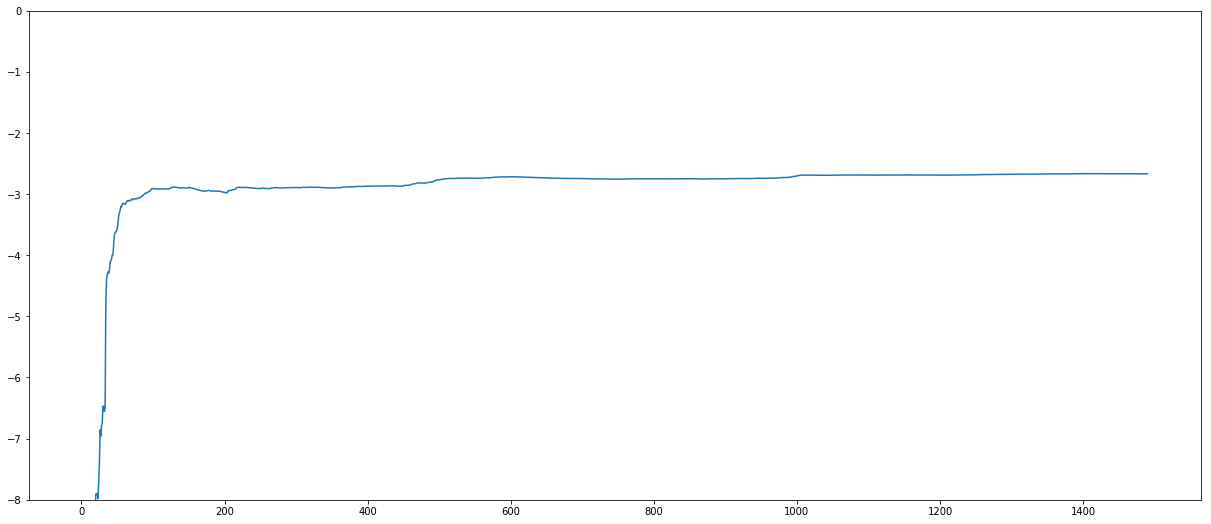

In [14]:
plt.figure(figsize=(21,9))
plt.plot(range(1491),log_lik_sgld)
plt.ylim(-8,0)

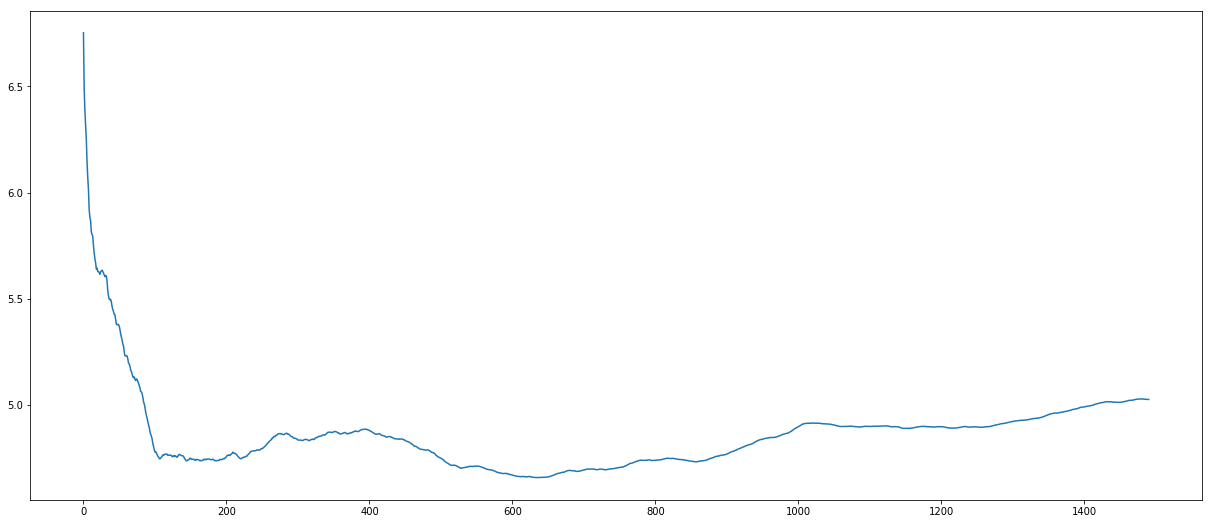

In [15]:
plt.figure(figsize=(21,9))
plt.plot(range(1491),test_rmse)

### SGFS

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain

class mlp(nn.Module):
    """
    "Standard" MLP with support with goodfellow's backprop trick
    """
    def __init__(self, architecture, nl=F.relu):
        super(mlp, self).__init__()

        self.nl = nl
        self.hidden_layers = nn.ModuleList([nn.Linear(architecture[i-1], architecture[i], bias=False) for i in range(1, len(architecture) - 1)])
        #nonlinearities = nn.ModuleList([nn.ReLU() for _ in self.hidden_layers])
        #interleaved = chain.from_iterable(zip(self.hidden_layers, nonlinearities))
        self.output_layer = nn.Linear(architecture[-2], architecture[-1], bias=False)


    def forward(self, x):
        """
        Forward pass that returns also returns
        * the activations (H) and
        * the linear combinations (Z)
        of each layer, to be able to use the trick from [1].

        Args:
            - x : The inputs of the network
        Returns:
            - logits
            - activations at each layer (including the inputs)
            - linear combinations at each layer
        > [1] EFFICIENT PER-EXAMPLE GRADIENT COMPUTATIONS
        > by Ian Goodfellow
        > https://arxiv.org/pdf/1510.01799.pdf
        """
        x = x.view(x.size(0), -1)

        # Save the model inputs, which are considered the activations of the 0'th layer.
        activations = [x]
        preactivations = []

        for l in self.hidden_layers:
            preactivation = l(x)
            x = self.nl(preactivation)

            # Save the activations and linear combinations from this layer.
            activations.append(x)
            preactivation.retain_grad()
            preactivation.requires_grad_(True)
            preactivations.append(preactivation)

        logits = self.output_layer(x)

        logits.retain_grad()
        logits.requires_grad_(True)
        preactivations.append(logits)

        return logits, activations, preactivations


In [ ]:
class evaluation_sgfs(object):
    def __init__(self, test_data, std_true, X_mean=None, X_std=None, y_mean=None, y_std=None):
        self.test_data = test_data
        self.std_true = std_true
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.n = 0.
        self.avg_prediction = 0.

    def fn(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)

                if (self.X_mean is not None) & (self.X_std is not None):
                    x = (x - self.X_mean) / self.X_std

                standard_pred, _, _ = model(x)

                if (self.y_mean is not None) & (self.y_std is not None):
                    standard_pred = standard_pred * self.y_std + self.y_mean

                self.avg_prediction += (standard_pred - self.avg_prediction) / self.n 


                norm = torch.distributions.normal.Normal(y, self.std_true)
                test_ll = norm.log_prob(self.avg_prediction).mean()



                error = nn.MSELoss(size_average=True)
                rmse = error(self.avg_prediction, y) ** 0.5
#                 test_ll = -0.5 * np.exp(-logvar) * (mean - Y_val.squeeze())**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi) #Y_true[None]
#                 test_ll = np.sum(np.sum(test_ll, -1), -1)
#                 test_ll = logsumexp(test_ll) - np.log(k)
#                 pppp = test_ll / N  # per point predictive probability
#                 rmse = np.mean((np.mean(mean, 0) - Y_val.squeeze())**2.)**0.5


                return rmse, test_ll

In [ ]:
import torch
import torchvision

import os

from torch import nn
from torchvision import transforms
import torch.nn.functional as F


import sgfs 







if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
epsilon =  1.



batch_size = 32
dataset_size = 456

# model_sgfs: preactivation and activation matrices required
network = mlp([13,50, 50, 1],nl=F.relu)
criterion = nn.MSELoss(size_average=False)

optim = sgfs.optim.sgfs(network, epsilon, lambda_, batch_size, dataset_size)
evaluate = evaluation_sgfs(test_loader, 1., X_train_mean, X_train_std, y_train_mean, y_train_std)

test_rmse = []
log_lik_sgfs = []
t = 1.

for epoch in range(1000):
    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        network.zero_grad()
        output, nonLinearities, preactivations = network(x)
        loss = 0.5 * criterion(output, y)
        preactivation_grads = torch.autograd.grad(loss, preactivations)
        # according to Goodfellow (see optim.py)
        # https://arxiv.org/pdf/1510.01799.pdf
        optim.element_backward(nonLinearities, preactivation_grads)
        optim.emp_fisher()


        optim.step()
        running_loss += loss * batch_size / dataset_size        
        
        if (t >= 1000) & (t % 10 == 0):
            rmse, log_lik = evaluate.fn(network)

#                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
            test_rmse.append(rmse)
            log_lik_sgfs.append(log_lik)
        
        t += 1.


    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))


In [6]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld 

import model




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr =3e-4
alpha = 0.99


batch_size = 32
dataset_size= 456



network = Model()
criterion = nn.MSELoss(size_average=False)

optim = psgld.optim.psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
# optim = torch.optim.RMSprop(network.parameters(), lr=1e-4, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
evaluate = evaluation(test_loader, 1., X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_psgld = []
test_rmse = []
log_lik_psgld = []
t = 1.

for epoch in range(2000):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        network.zero_grad()
        output = network(x)
        loss = 0.5 * criterion(output, y)
        loss.backward()
        optim.step()

        losses_psgld.append(loss)

        running_loss += loss * batch_size / dataset_size
        prediction = output.data.max(1)[1]
        accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


        if (t >= 300) & (t % 10 == 0):
            rmse, log_lik, predictions = evaluate.fn(network)
            test_rmse.append(rmse)
            log_lik_psgld.append(log_lik)

        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 10.7863
Epoch 1 - loss: 7.0868
Epoch 2 - loss: 5.8150
Epoch 3 - loss: 5.4487
Epoch 4 - loss: 5.1791
Epoch 5 - loss: 5.2694
Epoch 6 - loss: 5.0629
Epoch 7 - loss: 5.1398
Epoch 8 - loss: 5.0965
Epoch 9 - loss: 4.6204
Epoch 10 - loss: 5.0140
Epoch 11 - loss: 5.0611
Epoch 12 - loss: 4.5976
Epoch 13 - loss: 4.0514
Epoch 14 - loss: 3.9284
Epoch 15 - loss: 3.8224
Epoch 16 - loss: 3.7320
Epoch 17 - loss: 3.9860
Epoch 18 - loss: 3.9497


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Epoch 19 - loss: 3.8785
Epoch 20 - loss: 3.9880
Epoch 21 - loss: 3.9570
Epoch 22 - loss: 4.0539
Epoch 23 - loss: 4.3031
Epoch 24 - loss: 3.7286
Epoch 25 - loss: 3.6340
Epoch 26 - loss: 3.6744
Epoch 27 - loss: 3.6673
Epoch 28 - loss: 3.7937
Epoch 29 - loss: 3.8786
Epoch 30 - loss: 4.1271
Epoch 31 - loss: 4.1016
Epoch 32 - loss: 4.3046
Epoch 33 - loss: 4.1300
Epoch 34 - loss: 4.0801
Epoch 35 - loss: 4.0340
Epoch 36 - loss: 3.9303
Epoch 37 - loss: 3.8375
Epoch 38 - loss: 3.9651
Epoch 39 - loss: 4.1852
Epoch 40 - loss: 4.1267
Epoch 41 - loss: 4.2288
Epoch 42 - loss: 4.3838
Epoch 43 - loss: 4.3055
Epoch 44 - loss: 4.0893
Epoch 45 - loss: 4.6774
Epoch 46 - loss: 4.1313
Epoch 47 - loss: 3.8340
Epoch 48 - loss: 4.2582
Epoch 49 - loss: 3.9620
Epoch 50 - loss: 3.9183
Epoch 51 - loss: 4.1337
Epoch 52 - loss: 3.8128
Epoch 53 - loss: 3.6577
Epoch 54 - loss: 3.9679
Epoch 55 - loss: 3.9590
Epoch 56 - loss: 3.8881
Epoch 57 - loss: 4.1803
Epoch 58 - loss: 4.1364
Epoch 59 - loss: 4.1529
Epoch 60 - loss:

Epoch 353 - loss: 4.5921
Epoch 354 - loss: 4.8411
Epoch 355 - loss: 5.2300
Epoch 356 - loss: 5.0985
Epoch 357 - loss: 5.5819
Epoch 358 - loss: 5.3654
Epoch 359 - loss: 5.0980
Epoch 360 - loss: 5.2464
Epoch 361 - loss: 5.0331
Epoch 362 - loss: 4.9931
Epoch 363 - loss: 5.0550
Epoch 364 - loss: 5.1202
Epoch 365 - loss: 5.8237
Epoch 366 - loss: 5.1636
Epoch 367 - loss: 5.0938
Epoch 368 - loss: 5.1810
Epoch 369 - loss: 5.4128
Epoch 370 - loss: 4.7275
Epoch 371 - loss: 4.9310
Epoch 372 - loss: 4.7571
Epoch 373 - loss: 4.6575
Epoch 374 - loss: 4.6733
Epoch 375 - loss: 4.8118
Epoch 376 - loss: 4.7029
Epoch 377 - loss: 4.8955
Epoch 378 - loss: 4.8707
Epoch 379 - loss: 4.7385
Epoch 380 - loss: 4.7213
Epoch 381 - loss: 5.0154
Epoch 382 - loss: 5.4161
Epoch 383 - loss: 5.6828
Epoch 384 - loss: 5.0822
Epoch 385 - loss: 5.3423
Epoch 386 - loss: 5.4705
Epoch 387 - loss: 5.6237
Epoch 388 - loss: 5.6658
Epoch 389 - loss: 5.2787
Epoch 390 - loss: 5.4476
Epoch 391 - loss: 5.4953
Epoch 392 - loss: 5.2871


Epoch 686 - loss: 5.9455
Epoch 687 - loss: 5.7845
Epoch 688 - loss: 5.8113
Epoch 689 - loss: 5.3382
Epoch 690 - loss: 5.1313
Epoch 691 - loss: 5.7822
Epoch 692 - loss: 5.4946
Epoch 693 - loss: 5.2282
Epoch 694 - loss: 5.2323
Epoch 695 - loss: 5.2163
Epoch 696 - loss: 5.1985
Epoch 697 - loss: 5.1962
Epoch 698 - loss: 4.8703
Epoch 699 - loss: 5.2340
Epoch 700 - loss: 4.8393
Epoch 701 - loss: 5.3302
Epoch 702 - loss: 5.1169
Epoch 703 - loss: 5.1144
Epoch 704 - loss: 5.4980
Epoch 705 - loss: 5.4354
Epoch 706 - loss: 5.3343
Epoch 707 - loss: 5.5642
Epoch 708 - loss: 6.1899
Epoch 709 - loss: 6.0173
Epoch 710 - loss: 5.2674
Epoch 711 - loss: 5.9517
Epoch 712 - loss: 5.5291
Epoch 713 - loss: 5.6338
Epoch 714 - loss: 5.8068
Epoch 715 - loss: 4.9521
Epoch 716 - loss: 5.2862
Epoch 717 - loss: 5.4393
Epoch 718 - loss: 5.6289
Epoch 719 - loss: 5.6642
Epoch 720 - loss: 5.9730
Epoch 721 - loss: 5.6435
Epoch 722 - loss: 6.0439
Epoch 723 - loss: 5.8211
Epoch 724 - loss: 5.5718
Epoch 725 - loss: 5.5351


Epoch 1017 - loss: 5.5152
Epoch 1018 - loss: 5.4600
Epoch 1019 - loss: 5.6296
Epoch 1020 - loss: 5.9890
Epoch 1021 - loss: 6.0789
Epoch 1022 - loss: 6.3734
Epoch 1023 - loss: 5.9119
Epoch 1024 - loss: 5.9029
Epoch 1025 - loss: 6.3566
Epoch 1026 - loss: 6.0498
Epoch 1027 - loss: 6.1244
Epoch 1028 - loss: 5.9799
Epoch 1029 - loss: 5.9345
Epoch 1030 - loss: 6.1420
Epoch 1031 - loss: 6.0763
Epoch 1032 - loss: 6.2275
Epoch 1033 - loss: 5.5387
Epoch 1034 - loss: 5.4051
Epoch 1035 - loss: 5.4658
Epoch 1036 - loss: 5.1736
Epoch 1037 - loss: 4.9013
Epoch 1038 - loss: 4.8602
Epoch 1039 - loss: 5.1144
Epoch 1040 - loss: 5.4185
Epoch 1041 - loss: 5.6657
Epoch 1042 - loss: 5.0201
Epoch 1043 - loss: 5.3777
Epoch 1044 - loss: 4.9961
Epoch 1045 - loss: 4.6787
Epoch 1046 - loss: 4.8228
Epoch 1047 - loss: 4.5153
Epoch 1048 - loss: 4.8246
Epoch 1049 - loss: 4.9932
Epoch 1050 - loss: 5.1845
Epoch 1051 - loss: 4.6488
Epoch 1052 - loss: 4.9939
Epoch 1053 - loss: 4.7063
Epoch 1054 - loss: 4.8016
Epoch 1055 -

Epoch 1337 - loss: 5.3576
Epoch 1338 - loss: 5.3845
Epoch 1339 - loss: 4.8135
Epoch 1340 - loss: 4.8591
Epoch 1341 - loss: 4.2522
Epoch 1342 - loss: 4.5358
Epoch 1343 - loss: 4.7789
Epoch 1344 - loss: 4.5666
Epoch 1345 - loss: 4.7635
Epoch 1346 - loss: 4.5366
Epoch 1347 - loss: 4.9741
Epoch 1348 - loss: 4.9615
Epoch 1349 - loss: 5.6530
Epoch 1350 - loss: 5.0281
Epoch 1351 - loss: 5.0528
Epoch 1352 - loss: 4.7706
Epoch 1353 - loss: 5.3338
Epoch 1354 - loss: 4.9868
Epoch 1355 - loss: 4.8252
Epoch 1356 - loss: 4.8694
Epoch 1357 - loss: 4.8199
Epoch 1358 - loss: 4.7744
Epoch 1359 - loss: 4.8565
Epoch 1360 - loss: 4.6263
Epoch 1361 - loss: 4.5371
Epoch 1362 - loss: 5.1033
Epoch 1363 - loss: 5.1003
Epoch 1364 - loss: 4.9535
Epoch 1365 - loss: 4.7779
Epoch 1366 - loss: 4.5670
Epoch 1367 - loss: 4.6789
Epoch 1368 - loss: 4.7040
Epoch 1369 - loss: 4.5895
Epoch 1370 - loss: 4.3325
Epoch 1371 - loss: 4.4967
Epoch 1372 - loss: 4.6827
Epoch 1373 - loss: 4.8656
Epoch 1374 - loss: 4.4369
Epoch 1375 -

Epoch 1655 - loss: 4.7381
Epoch 1656 - loss: 4.1905
Epoch 1657 - loss: 4.6098
Epoch 1658 - loss: 4.9417
Epoch 1659 - loss: 4.6416
Epoch 1660 - loss: 4.4809
Epoch 1661 - loss: 4.3905
Epoch 1662 - loss: 5.0109
Epoch 1663 - loss: 4.4300
Epoch 1664 - loss: 4.5294
Epoch 1665 - loss: 4.0910
Epoch 1666 - loss: 4.2851
Epoch 1667 - loss: 4.3080
Epoch 1668 - loss: 5.6801
Epoch 1669 - loss: 5.3377
Epoch 1670 - loss: 4.8635
Epoch 1671 - loss: 4.7645
Epoch 1672 - loss: 4.8463
Epoch 1673 - loss: 5.0676
Epoch 1674 - loss: 4.7800
Epoch 1675 - loss: 4.8269
Epoch 1676 - loss: 4.9649
Epoch 1677 - loss: 4.7688
Epoch 1678 - loss: 4.5733
Epoch 1679 - loss: 4.4528
Epoch 1680 - loss: 4.9553
Epoch 1681 - loss: 4.0440
Epoch 1682 - loss: 4.6246
Epoch 1683 - loss: 5.1611
Epoch 1684 - loss: 4.3235
Epoch 1685 - loss: 4.4546
Epoch 1686 - loss: 4.7997
Epoch 1687 - loss: 4.8325
Epoch 1688 - loss: 4.5847
Epoch 1689 - loss: 4.6438
Epoch 1690 - loss: 4.2176
Epoch 1691 - loss: 4.6152
Epoch 1692 - loss: 4.4612
Epoch 1693 -

Epoch 1971 - loss: 3.9740
Epoch 1972 - loss: 4.5339
Epoch 1973 - loss: 4.6843
Epoch 1974 - loss: 4.5513
Epoch 1975 - loss: 4.1461
Epoch 1976 - loss: 4.1375
Epoch 1977 - loss: 4.4364
Epoch 1978 - loss: 4.1047
Epoch 1979 - loss: 3.9316
Epoch 1980 - loss: 4.7910
Epoch 1981 - loss: 4.3394
Epoch 1982 - loss: 4.4135
Epoch 1983 - loss: 4.5735
Epoch 1984 - loss: 4.6059
Epoch 1985 - loss: 4.7609
Epoch 1986 - loss: 4.7438
Epoch 1987 - loss: 4.8331
Epoch 1988 - loss: 3.8353
Epoch 1989 - loss: 4.2197
Epoch 1990 - loss: 4.5528
Epoch 1991 - loss: 4.4742
Epoch 1992 - loss: 4.1521
Epoch 1993 - loss: 4.3971
Epoch 1994 - loss: 4.0543
Epoch 1995 - loss: 4.1566
Epoch 1996 - loss: 4.2412
Epoch 1997 - loss: 4.4911
Epoch 1998 - loss: 4.2530
Epoch 1999 - loss: 3.8209


(-6, 0)

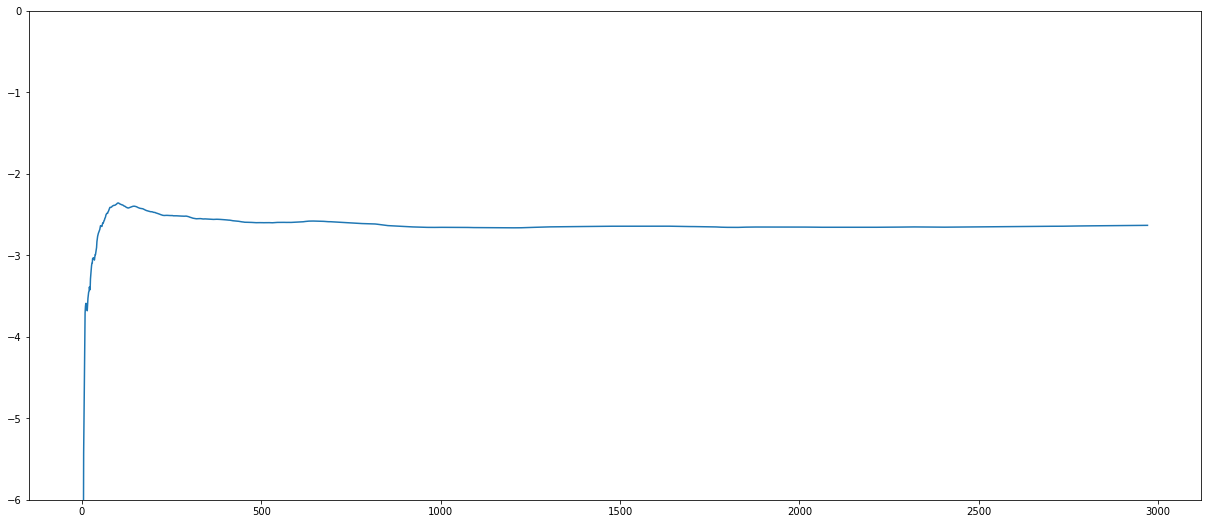

In [7]:
plt.figure(figsize=(21,9))
plt.plot(range(2971),log_lik_psgld)
plt.ylim(-6,0)

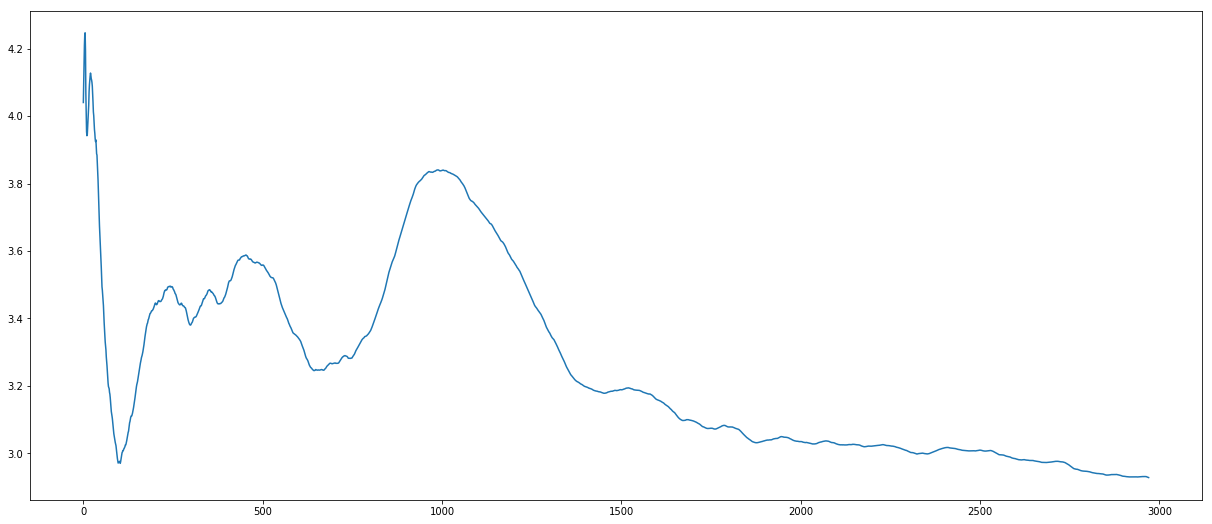

In [8]:
plt.figure(figsize=(21,9))
plt.plot(range(2971),test_rmse)

In [10]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")






batch_size = 32
dataset_size=456




network = Model()
criterion = nn.MSELoss(size_average=False)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon= 0.01, l2=1e-3, invert_every=1)
evaluate = evaluation(test_loader, 1., X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_ksgfs = []
log_lik_ksgfs = []
test_rmse = []
t = 1.

for epoch in range(2000):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = 0.5 * criterion(output, y)
        loss.backward()
        optim.step()


        losses_ksgfs.append(loss)
        running_loss += loss * batch_size / dataset_size
        prediction = output.data.max(1)[1]
        accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size

        if (t >= 1000) & (t % 100 == 0):
            rmse, log_lik, predictions = evaluate.fn(network)
            test_rmse.append(rmse)
            log_lik_ksgfs.append(log_lik)
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 9.0136
Epoch 1 - loss: 4.9733
Epoch 2 - loss: 4.7476
Epoch 3 - loss: 4.5567
Epoch 4 - loss: 4.5068
Epoch 5 - loss: 4.4330
Epoch 6 - loss: 4.3643
Epoch 7 - loss: 4.2149
Epoch 8 - loss: 4.0427
Epoch 9 - loss: 3.9979
Epoch 10 - loss: 3.7794
Epoch 11 - loss: 3.8047
Epoch 12 - loss: 3.7151
Epoch 13 - loss: 3.7159
Epoch 14 - loss: 3.5667
Epoch 15 - loss: 3.4455
Epoch 16 - loss: 3.3846
Epoch 17 - loss: 3.2903
Epoch 18 - loss: 3.1251
Epoch 19 - loss: 3.0746
Epoch 20 - loss: 3.1016
Epoch 21 - loss: 3.1622
Epoch 22 - loss: 2.7854
Epoch 23 - loss: 2.6871
Epoch 24 - loss: 2.6647
Epoch 25 - loss: 2.6389
Epoch 26 - loss: 2.5896
Epoch 27 - loss: 2.4372
Epoch 28 - loss: 2.4004
Epoch 29 - loss: 2.2435
Epoch 30 - loss: 2.2814
Epoch 31 - loss: 2.3024
Epoch 32 - loss: 2.2128
Epoch 33 - loss: 2.1745
Epoch 34 - loss: 2.1191
Epoch 35 - loss: 1.9814
Epoch 36 - loss: 1.9640
Epoch 37 - loss: 1.8453
Epoch 38 - loss: 1.9180
Epoch 39 - loss: 2.0284
Epoch 40 - loss: 1.9359
Epoch 41 - loss: 1.7749
Ep

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Epoch 66 - loss: 1.3789
Epoch 67 - loss: 1.4574
Epoch 68 - loss: 1.3091
Epoch 69 - loss: 1.3779
Epoch 70 - loss: 1.1462
Epoch 71 - loss: 1.3213
Epoch 72 - loss: 1.2852
Epoch 73 - loss: 1.2758
Epoch 74 - loss: 1.3539
Epoch 75 - loss: 1.2408
Epoch 76 - loss: 1.2766
Epoch 77 - loss: 1.4209
Epoch 78 - loss: 1.2618
Epoch 79 - loss: 1.1823
Epoch 80 - loss: 1.3306
Epoch 81 - loss: 1.3831
Epoch 82 - loss: 1.3095
Epoch 83 - loss: 1.2976
Epoch 84 - loss: 1.2602
Epoch 85 - loss: 1.1970
Epoch 86 - loss: 1.2137
Epoch 87 - loss: 1.1894
Epoch 88 - loss: 1.2639
Epoch 89 - loss: 1.3193
Epoch 90 - loss: 1.1727
Epoch 91 - loss: 1.2018
Epoch 92 - loss: 1.1359
Epoch 93 - loss: 1.2720
Epoch 94 - loss: 1.1447
Epoch 95 - loss: 1.1254
Epoch 96 - loss: 1.3086
Epoch 97 - loss: 1.1858
Epoch 98 - loss: 1.1594
Epoch 99 - loss: 1.2275
Epoch 100 - loss: 1.1427
Epoch 101 - loss: 1.1043
Epoch 102 - loss: 1.1337
Epoch 103 - loss: 1.1091
Epoch 104 - loss: 1.0831
Epoch 105 - loss: 1.0882
Epoch 106 - loss: 1.1533
Epoch 107

Epoch 396 - loss: 0.8345
Epoch 397 - loss: 0.9349
Epoch 398 - loss: 0.9321
Epoch 399 - loss: 0.9371
Epoch 400 - loss: 0.8686
Epoch 401 - loss: 0.8252
Epoch 402 - loss: 0.8512
Epoch 403 - loss: 0.8870
Epoch 404 - loss: 0.9119
Epoch 405 - loss: 0.9105
Epoch 406 - loss: 0.8591
Epoch 407 - loss: 0.8538
Epoch 408 - loss: 0.8345
Epoch 409 - loss: 0.8682
Epoch 410 - loss: 0.8170
Epoch 411 - loss: 0.8175
Epoch 412 - loss: 0.8541
Epoch 413 - loss: 0.9021
Epoch 414 - loss: 0.9268
Epoch 415 - loss: 0.9353
Epoch 416 - loss: 0.8105
Epoch 417 - loss: 0.8632
Epoch 418 - loss: 0.9041
Epoch 419 - loss: 0.9745
Epoch 420 - loss: 0.9563
Epoch 421 - loss: 0.8880
Epoch 422 - loss: 0.9343
Epoch 423 - loss: 0.8521
Epoch 424 - loss: 0.9189
Epoch 425 - loss: 0.8461
Epoch 426 - loss: 0.8067
Epoch 427 - loss: 0.8728
Epoch 428 - loss: 0.8665
Epoch 429 - loss: 0.9126
Epoch 430 - loss: 0.9171
Epoch 431 - loss: 0.8615
Epoch 432 - loss: 0.8907
Epoch 433 - loss: 0.8501
Epoch 434 - loss: 0.9462
Epoch 435 - loss: 0.8607


Epoch 724 - loss: 0.8266
Epoch 725 - loss: 0.8643
Epoch 726 - loss: 0.8522
Epoch 727 - loss: 0.8334
Epoch 728 - loss: 0.9290
Epoch 729 - loss: 0.8669
Epoch 730 - loss: 0.8849
Epoch 731 - loss: 0.8797
Epoch 732 - loss: 0.8640
Epoch 733 - loss: 0.9208
Epoch 734 - loss: 0.9642
Epoch 735 - loss: 0.8946
Epoch 736 - loss: 0.9042
Epoch 737 - loss: 0.9188
Epoch 738 - loss: 0.9356
Epoch 739 - loss: 0.9320
Epoch 740 - loss: 1.0177
Epoch 741 - loss: 0.8088
Epoch 742 - loss: 0.8790
Epoch 743 - loss: 0.9789
Epoch 744 - loss: 0.8775
Epoch 745 - loss: 0.9161
Epoch 746 - loss: 0.9050
Epoch 747 - loss: 0.9565
Epoch 748 - loss: 0.9946
Epoch 749 - loss: 0.8623
Epoch 750 - loss: 0.8777
Epoch 751 - loss: 0.8516
Epoch 752 - loss: 0.8707
Epoch 753 - loss: 1.0304
Epoch 754 - loss: 0.8797
Epoch 755 - loss: 0.8432
Epoch 756 - loss: 0.8388
Epoch 757 - loss: 0.9137
Epoch 758 - loss: 0.8342
Epoch 759 - loss: 0.8640
Epoch 760 - loss: 0.8461
Epoch 761 - loss: 0.7703
Epoch 762 - loss: 0.8513
Epoch 763 - loss: 0.8869


Epoch 1050 - loss: 0.7597
Epoch 1051 - loss: 0.7464
Epoch 1052 - loss: 0.8999
Epoch 1053 - loss: 0.7819
Epoch 1054 - loss: 0.7858
Epoch 1055 - loss: 0.8053
Epoch 1056 - loss: 0.8157
Epoch 1057 - loss: 0.7700
Epoch 1058 - loss: 0.8491
Epoch 1059 - loss: 0.8900
Epoch 1060 - loss: 0.8379
Epoch 1061 - loss: 0.7982
Epoch 1062 - loss: 0.8320
Epoch 1063 - loss: 0.8358
Epoch 1064 - loss: 0.8058
Epoch 1065 - loss: 0.8715
Epoch 1066 - loss: 0.8442
Epoch 1067 - loss: 0.9522
Epoch 1068 - loss: 0.8049
Epoch 1069 - loss: 0.8993
Epoch 1070 - loss: 0.9369
Epoch 1071 - loss: 0.8595
Epoch 1072 - loss: 0.8924
Epoch 1073 - loss: 0.9145
Epoch 1074 - loss: 0.8587
Epoch 1075 - loss: 0.8155
Epoch 1076 - loss: 0.9860
Epoch 1077 - loss: 0.9023
Epoch 1078 - loss: 0.8983
Epoch 1079 - loss: 0.9341
Epoch 1080 - loss: 0.9425
Epoch 1081 - loss: 0.8002
Epoch 1082 - loss: 0.7714
Epoch 1083 - loss: 0.8230
Epoch 1084 - loss: 0.8267
Epoch 1085 - loss: 0.8974
Epoch 1086 - loss: 0.8268
Epoch 1087 - loss: 0.8163
Epoch 1088 -

Epoch 1366 - loss: 0.7393
Epoch 1367 - loss: 0.7797
Epoch 1368 - loss: 0.8346
Epoch 1369 - loss: 0.7995
Epoch 1370 - loss: 0.7769
Epoch 1371 - loss: 0.7438
Epoch 1372 - loss: 0.7683
Epoch 1373 - loss: 0.8356
Epoch 1374 - loss: 0.7687
Epoch 1375 - loss: 0.6766
Epoch 1376 - loss: 0.6836
Epoch 1377 - loss: 0.7724
Epoch 1378 - loss: 0.7765
Epoch 1379 - loss: 0.6734
Epoch 1380 - loss: 0.7052
Epoch 1381 - loss: 0.7256
Epoch 1382 - loss: 0.8055
Epoch 1383 - loss: 0.7413
Epoch 1384 - loss: 0.7597
Epoch 1385 - loss: 0.8030
Epoch 1386 - loss: 0.8413
Epoch 1387 - loss: 0.8161
Epoch 1388 - loss: 0.7629
Epoch 1389 - loss: 0.8136
Epoch 1390 - loss: 0.8649
Epoch 1391 - loss: 0.9174
Epoch 1392 - loss: 0.7386
Epoch 1393 - loss: 0.7685
Epoch 1394 - loss: 0.7593
Epoch 1395 - loss: 0.8119
Epoch 1396 - loss: 0.7742
Epoch 1397 - loss: 0.6751
Epoch 1398 - loss: 0.7517
Epoch 1399 - loss: 0.7850
Epoch 1400 - loss: 0.7745
Epoch 1401 - loss: 0.8032
Epoch 1402 - loss: 0.8012
Epoch 1403 - loss: 0.7612
Epoch 1404 -

Epoch 1683 - loss: 0.7097
Epoch 1684 - loss: 0.7316
Epoch 1685 - loss: 0.8469
Epoch 1686 - loss: 0.9482
Epoch 1687 - loss: 0.7960
Epoch 1688 - loss: 0.7900
Epoch 1689 - loss: 0.8039
Epoch 1690 - loss: 0.8157
Epoch 1691 - loss: 0.8837
Epoch 1692 - loss: 0.8990
Epoch 1693 - loss: 0.7652
Epoch 1694 - loss: 0.6946
Epoch 1695 - loss: 0.8590
Epoch 1696 - loss: 0.8406
Epoch 1697 - loss: 0.7143
Epoch 1698 - loss: 0.7733
Epoch 1699 - loss: 0.8330
Epoch 1700 - loss: 0.8527
Epoch 1701 - loss: 0.8249
Epoch 1702 - loss: 0.8513
Epoch 1703 - loss: 0.8629
Epoch 1704 - loss: 0.8814
Epoch 1705 - loss: 0.7762
Epoch 1706 - loss: 0.8005
Epoch 1707 - loss: 0.7698
Epoch 1708 - loss: 0.7842
Epoch 1709 - loss: 0.8156
Epoch 1710 - loss: 0.8255
Epoch 1711 - loss: 0.7734
Epoch 1712 - loss: 0.7786
Epoch 1713 - loss: 0.8493
Epoch 1714 - loss: 0.7917
Epoch 1715 - loss: 0.7277
Epoch 1716 - loss: 0.7493
Epoch 1717 - loss: 0.7634
Epoch 1718 - loss: 0.7744
Epoch 1719 - loss: 0.7774
Epoch 1720 - loss: 0.7060
Epoch 1721 -

Epoch 1999 - loss: 0.6967


In [11]:
log_lik_ksgfs[-1]

tensor(-2.5987)

In [12]:
gelman_rubin(predictions[:,:1491])

NameError: name 'gelman_rubin' is not defined

In [ ]:
ess(predictions[:,1:])

In [13]:
np.max(log_lik_ksgfs[3:])

-2.597772

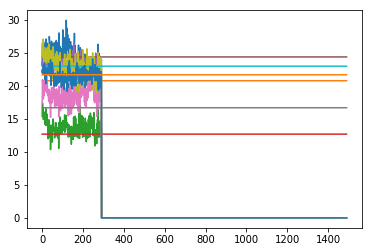

In [15]:
plt.plot(range(1491),predictions[0,:1491].numpy())
plt.plot(range(1491),np.linspace(y[0],y[0],1491))
plt.plot(range(1491),predictions[1,:1491].numpy())
plt.plot(range(1491),np.linspace(y[1],y[1],1491))
plt.plot(range(1491),predictions[2,:1491].numpy())
plt.plot(range(1491),np.linspace(y[2],y[2],1491))
plt.plot(range(1491),predictions[3,:1491].numpy())
plt.plot(range(1491),np.linspace(y[3],y[3],1491))
plt.plot(range(1491),predictions[4,:1491].numpy())
plt.plot(range(1491),np.linspace(y[4],y[4],1491))
plt.plot(range(1491),predictions[5,:1491].numpy())
plt.plot(range(1491),np.linspace(y[5],y[5],1491))

In [14]:
for x,y in iter(test_loader):
    x,y

(-8, 0)

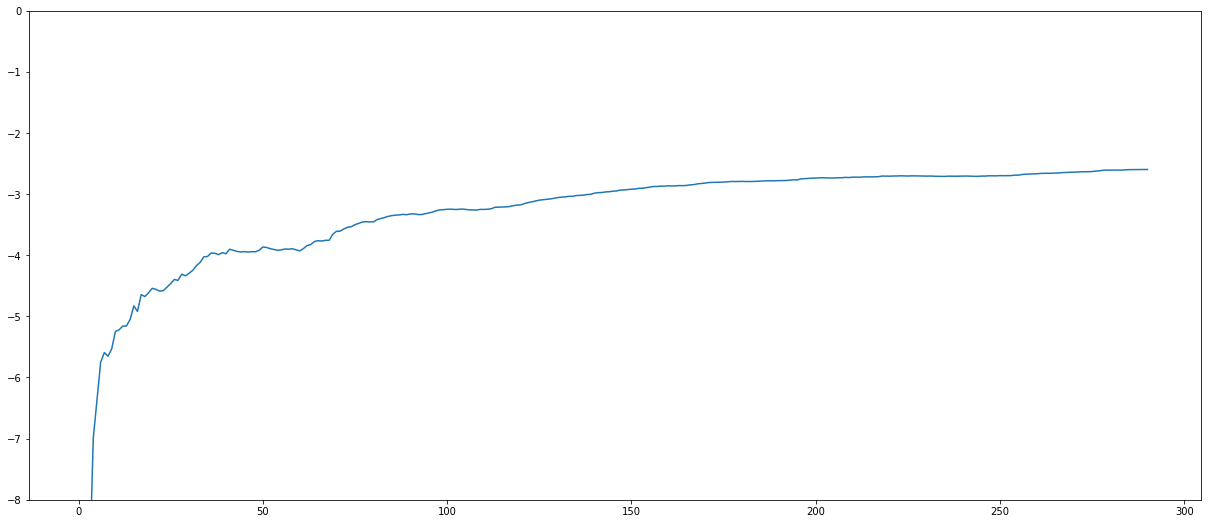

In [17]:
plt.figure(figsize=(21,9))
plt.plot(range(291), log_lik_ksgfs)
plt.ylim(-8,0)

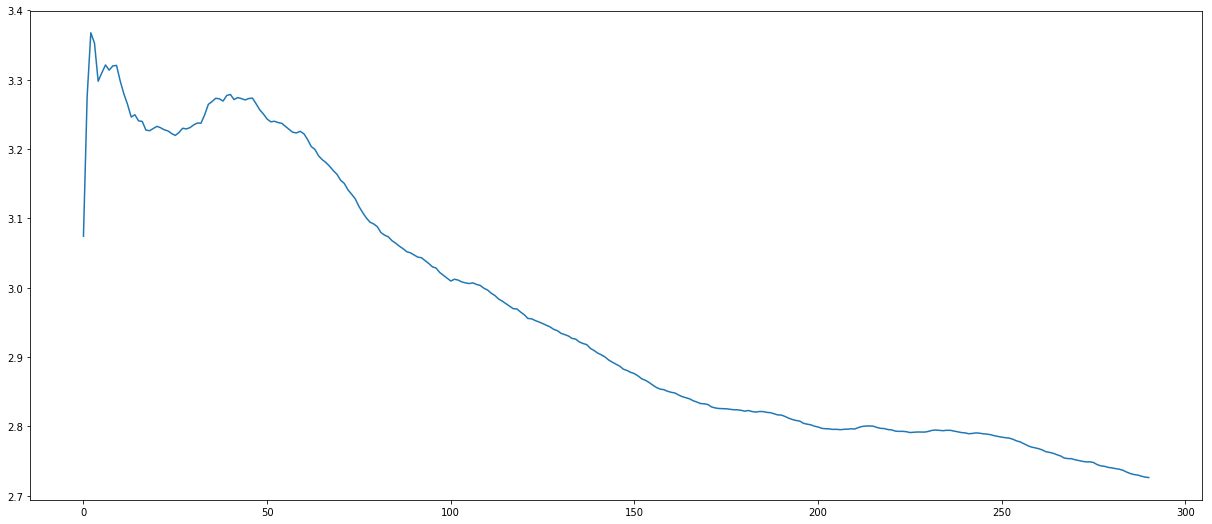

In [18]:
plt.figure(figsize=(21,9))
plt.plot(range(291), test_rmse)

In [30]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
#from numpy.random import RandomState

import ksgld



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


batch_size = 32
dataset_size=456




network = Model()
criterion = nn.MSELoss(size_average=False)
#eps=5e-2

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=5e-6, l2=1e-3, invert_every=1)
evaluate = evaluation(test_loader, 1., X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_ksgld = []
log_lik_ksgld = []
test_rmse = []
t = 1.

for epoch in range(2000):
    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = 0.5 * criterion(output, y)
        loss.backward()
        optim.step()

        losses_ksgld.append(loss)
        running_loss += loss * batch_size / dataset_size

        if (t >= 1000) & (t % 100 == 0):
            with torch.autograd.no_grad():
#                 tau = 1.
#                 T = 50.
#                 rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
                rmse, log_lik, predictions = evaluate.fn(network)
                test_rmse.append(rmse)
                log_lik_ksgld.append(log_lik)
        t += 1.


    print("Epoch {:d} - loss: {:.4f} ".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 18.2004 
Epoch 1 - loss: 18.0272 
Epoch 2 - loss: 17.4685 
Epoch 3 - loss: 17.1574 
Epoch 4 - loss: 16.9606 
Epoch 5 - loss: 16.5833 
Epoch 6 - loss: 17.0737 
Epoch 7 - loss: 16.6146 
Epoch 8 - loss: 16.3586 
Epoch 9 - loss: 16.2886 
Epoch 10 - loss: 16.5684 
Epoch 11 - loss: 16.1431 
Epoch 12 - loss: 15.4500 
Epoch 13 - loss: 14.8857 
Epoch 14 - loss: 14.4924 
Epoch 15 - loss: 14.7798 
Epoch 16 - loss: 14.8421 
Epoch 17 - loss: 14.1531 
Epoch 18 - loss: 13.5190 
Epoch 19 - loss: 13.1277 
Epoch 20 - loss: 13.3998 
Epoch 21 - loss: 13.1738 
Epoch 22 - loss: 12.9854 
Epoch 23 - loss: 12.5860 
Epoch 24 - loss: 12.0089 
Epoch 25 - loss: 11.7091 
Epoch 26 - loss: 11.1895 
Epoch 27 - loss: 11.1886 
Epoch 28 - loss: 11.1622 
Epoch 29 - loss: 11.0068 
Epoch 30 - loss: 10.9962 
Epoch 31 - loss: 11.2761 
Epoch 32 - loss: 11.0587 
Epoch 33 - loss: 11.4754 
Epoch 34 - loss: 11.3528 
Epoch 35 - loss: 11.3487 
Epoch 36 - loss: 11.4424 
Epoch 37 - loss: 11.3536 
Epoch 38 - loss: 11.70

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Epoch 66 - loss: 8.9596 
Epoch 67 - loss: 9.1864 
Epoch 68 - loss: 9.1451 
Epoch 69 - loss: 9.0135 
Epoch 70 - loss: 8.7141 
Epoch 71 - loss: 8.2577 
Epoch 72 - loss: 8.1767 
Epoch 73 - loss: 7.8184 
Epoch 74 - loss: 7.9156 
Epoch 75 - loss: 7.6973 
Epoch 76 - loss: 6.7171 
Epoch 77 - loss: 6.6434 
Epoch 78 - loss: 6.8539 
Epoch 79 - loss: 6.8667 
Epoch 80 - loss: 6.9078 
Epoch 81 - loss: 6.7468 
Epoch 82 - loss: 6.7396 
Epoch 83 - loss: 6.6291 
Epoch 84 - loss: 6.4872 
Epoch 85 - loss: 6.5920 
Epoch 86 - loss: 6.6232 
Epoch 87 - loss: 6.6923 
Epoch 88 - loss: 6.5015 
Epoch 89 - loss: 6.7684 
Epoch 90 - loss: 6.7253 
Epoch 91 - loss: 6.6271 
Epoch 92 - loss: 6.3354 
Epoch 93 - loss: 6.2220 
Epoch 94 - loss: 6.1224 
Epoch 95 - loss: 6.1971 
Epoch 96 - loss: 6.0527 
Epoch 97 - loss: 6.0439 
Epoch 98 - loss: 6.0202 
Epoch 99 - loss: 6.1006 
Epoch 100 - loss: 6.0696 
Epoch 101 - loss: 6.1297 
Epoch 102 - loss: 6.0720 
Epoch 103 - loss: 6.1868 
Epoch 104 - loss: 6.4348 
Epoch 105 - loss: 6.

Epoch 383 - loss: 7.4948 
Epoch 384 - loss: 8.6704 
Epoch 385 - loss: 8.3429 
Epoch 386 - loss: 8.7681 
Epoch 387 - loss: 9.1203 
Epoch 388 - loss: 8.0470 
Epoch 389 - loss: 8.9295 
Epoch 390 - loss: 9.4600 
Epoch 391 - loss: 11.0449 
Epoch 392 - loss: 10.6920 
Epoch 393 - loss: 12.1831 
Epoch 394 - loss: 12.4962 
Epoch 395 - loss: 11.1996 
Epoch 396 - loss: 7.8921 
Epoch 397 - loss: 6.3169 
Epoch 398 - loss: 5.6053 
Epoch 399 - loss: 5.1737 
Epoch 400 - loss: 5.1984 
Epoch 401 - loss: 6.6053 
Epoch 402 - loss: 8.1991 
Epoch 403 - loss: 10.4197 
Epoch 404 - loss: 10.4101 
Epoch 405 - loss: 12.2289 
Epoch 406 - loss: 14.5938 
Epoch 407 - loss: 12.2041 
Epoch 408 - loss: 10.4416 
Epoch 409 - loss: 10.1495 
Epoch 410 - loss: 10.0535 
Epoch 411 - loss: 10.6177 
Epoch 412 - loss: 11.3545 
Epoch 413 - loss: 10.0676 
Epoch 414 - loss: 10.1499 
Epoch 415 - loss: 9.3047 
Epoch 416 - loss: 10.5792 
Epoch 417 - loss: 12.2847 
Epoch 418 - loss: 14.1005 
Epoch 419 - loss: 17.1460 
Epoch 420 - loss:

Epoch 695 - loss: 15.6370 
Epoch 696 - loss: 15.9797 
Epoch 697 - loss: 15.5622 
Epoch 698 - loss: 16.3069 
Epoch 699 - loss: 16.1029 
Epoch 700 - loss: 16.0178 
Epoch 701 - loss: 15.7986 
Epoch 702 - loss: 15.0998 
Epoch 703 - loss: 15.4088 
Epoch 704 - loss: 14.7110 
Epoch 705 - loss: 13.8002 
Epoch 706 - loss: 13.2467 
Epoch 707 - loss: 13.7730 
Epoch 708 - loss: 14.6282 
Epoch 709 - loss: 15.2501 
Epoch 710 - loss: 13.5674 
Epoch 711 - loss: 11.9574 
Epoch 712 - loss: 11.7751 
Epoch 713 - loss: 10.8590 
Epoch 714 - loss: 10.4522 
Epoch 715 - loss: 10.7139 
Epoch 716 - loss: 9.6780 
Epoch 717 - loss: 10.1470 
Epoch 718 - loss: 10.6199 
Epoch 719 - loss: 9.6487 
Epoch 720 - loss: 9.6898 
Epoch 721 - loss: 9.8131 
Epoch 722 - loss: 9.8583 
Epoch 723 - loss: 10.3748 
Epoch 724 - loss: 10.7400 
Epoch 725 - loss: 11.7336 
Epoch 726 - loss: 12.4372 
Epoch 727 - loss: 11.8830 
Epoch 728 - loss: 10.5014 
Epoch 729 - loss: 10.8965 
Epoch 730 - loss: 9.6437 
Epoch 731 - loss: 9.1059 
Epoch 73

Epoch 1006 - loss: 5.5761 
Epoch 1007 - loss: 6.0835 
Epoch 1008 - loss: 6.3042 
Epoch 1009 - loss: 5.9887 
Epoch 1010 - loss: 6.5920 
Epoch 1011 - loss: 6.6525 
Epoch 1012 - loss: 6.9404 
Epoch 1013 - loss: 6.1470 
Epoch 1014 - loss: 6.0889 
Epoch 1015 - loss: 6.4282 
Epoch 1016 - loss: 6.1360 
Epoch 1017 - loss: 6.1366 
Epoch 1018 - loss: 6.1970 
Epoch 1019 - loss: 5.9930 
Epoch 1020 - loss: 5.8219 
Epoch 1021 - loss: 5.8388 
Epoch 1022 - loss: 6.1545 
Epoch 1023 - loss: 6.5703 
Epoch 1024 - loss: 7.5082 
Epoch 1025 - loss: 9.5130 
Epoch 1026 - loss: 11.4765 
Epoch 1027 - loss: 11.1166 
Epoch 1028 - loss: 11.6518 
Epoch 1029 - loss: 8.7493 
Epoch 1030 - loss: 8.4289 
Epoch 1031 - loss: 7.7682 
Epoch 1032 - loss: 7.2666 
Epoch 1033 - loss: 7.0597 
Epoch 1034 - loss: 7.7031 
Epoch 1035 - loss: 7.6709 
Epoch 1036 - loss: 7.7266 
Epoch 1037 - loss: 7.6669 
Epoch 1038 - loss: 7.5200 
Epoch 1039 - loss: 7.4431 
Epoch 1040 - loss: 7.4935 
Epoch 1041 - loss: 8.2518 
Epoch 1042 - loss: 7.6430

Epoch 1306 - loss: 13.2840 
Epoch 1307 - loss: 12.9372 
Epoch 1308 - loss: 14.8238 
Epoch 1309 - loss: 15.0404 
Epoch 1310 - loss: 12.9860 
Epoch 1311 - loss: 8.7459 
Epoch 1312 - loss: 9.1497 
Epoch 1313 - loss: 10.2667 
Epoch 1314 - loss: 10.5195 
Epoch 1315 - loss: 10.9190 
Epoch 1316 - loss: 11.5664 
Epoch 1317 - loss: 9.0946 
Epoch 1318 - loss: 8.3862 
Epoch 1319 - loss: 8.4666 
Epoch 1320 - loss: 10.0624 
Epoch 1321 - loss: 11.5971 
Epoch 1322 - loss: 12.2405 
Epoch 1323 - loss: 9.3963 
Epoch 1324 - loss: 8.5856 
Epoch 1325 - loss: 8.3998 
Epoch 1326 - loss: 7.0181 
Epoch 1327 - loss: 7.0447 
Epoch 1328 - loss: 8.5536 
Epoch 1329 - loss: 7.7760 
Epoch 1330 - loss: 6.8833 
Epoch 1331 - loss: 7.4481 
Epoch 1332 - loss: 6.9667 
Epoch 1333 - loss: 8.3473 
Epoch 1334 - loss: 10.5377 
Epoch 1335 - loss: 10.6590 
Epoch 1336 - loss: 10.8987 
Epoch 1337 - loss: 10.8071 
Epoch 1338 - loss: 13.9016 
Epoch 1339 - loss: 13.1425 
Epoch 1340 - loss: 11.9671 
Epoch 1341 - loss: 9.9526 
Epoch 134

Epoch 1605 - loss: 22.1976 
Epoch 1606 - loss: 27.8759 
Epoch 1607 - loss: 23.7050 
Epoch 1608 - loss: 25.3076 
Epoch 1609 - loss: 34.8788 
Epoch 1610 - loss: 30.3021 
Epoch 1611 - loss: 22.0494 
Epoch 1612 - loss: 15.4366 
Epoch 1613 - loss: 11.8777 
Epoch 1614 - loss: 11.2296 
Epoch 1615 - loss: 9.0126 
Epoch 1616 - loss: 7.4079 
Epoch 1617 - loss: 8.3420 
Epoch 1618 - loss: 7.2398 
Epoch 1619 - loss: 6.3513 
Epoch 1620 - loss: 5.8814 
Epoch 1621 - loss: 6.7805 
Epoch 1622 - loss: 6.8443 
Epoch 1623 - loss: 7.4890 
Epoch 1624 - loss: 7.1975 
Epoch 1625 - loss: 7.4983 
Epoch 1626 - loss: 7.1289 
Epoch 1627 - loss: 7.8912 
Epoch 1628 - loss: 7.0796 
Epoch 1629 - loss: 6.1896 
Epoch 1630 - loss: 5.8044 
Epoch 1631 - loss: 5.8638 
Epoch 1632 - loss: 5.6386 
Epoch 1633 - loss: 5.4959 
Epoch 1634 - loss: 5.6332 
Epoch 1635 - loss: 5.4680 
Epoch 1636 - loss: 5.4146 
Epoch 1637 - loss: 6.1361 
Epoch 1638 - loss: 7.2122 
Epoch 1639 - loss: 6.3348 
Epoch 1640 - loss: 6.1503 
Epoch 1641 - loss:

Epoch 1901 - loss: 12.0127 
Epoch 1902 - loss: 7.9522 
Epoch 1903 - loss: 6.0293 
Epoch 1904 - loss: 6.3213 
Epoch 1905 - loss: 6.1745 
Epoch 1906 - loss: 5.8173 
Epoch 1907 - loss: 5.6351 
Epoch 1908 - loss: 5.6072 
Epoch 1909 - loss: 5.7353 
Epoch 1910 - loss: 5.4855 
Epoch 1911 - loss: 5.8138 
Epoch 1912 - loss: 6.9843 
Epoch 1913 - loss: 6.5086 
Epoch 1914 - loss: 7.2808 
Epoch 1915 - loss: 7.8685 
Epoch 1916 - loss: 7.3211 
Epoch 1917 - loss: 6.4356 
Epoch 1918 - loss: 5.8162 
Epoch 1919 - loss: 5.8488 
Epoch 1920 - loss: 5.9617 
Epoch 1921 - loss: 6.0932 
Epoch 1922 - loss: 7.5530 
Epoch 1923 - loss: 9.0068 
Epoch 1924 - loss: 8.6649 
Epoch 1925 - loss: 7.8817 
Epoch 1926 - loss: 7.1863 
Epoch 1927 - loss: 6.7963 
Epoch 1928 - loss: 7.0510 
Epoch 1929 - loss: 7.7685 
Epoch 1930 - loss: 8.1469 
Epoch 1931 - loss: 7.7722 
Epoch 1932 - loss: 7.3973 
Epoch 1933 - loss: 7.6669 
Epoch 1934 - loss: 10.4431 
Epoch 1935 - loss: 11.5636 
Epoch 1936 - loss: 10.1610 
Epoch 1937 - loss: 9.236

In [31]:
log_lik_ksgld[-1]

tensor(-2.8817)

(-10, 0)

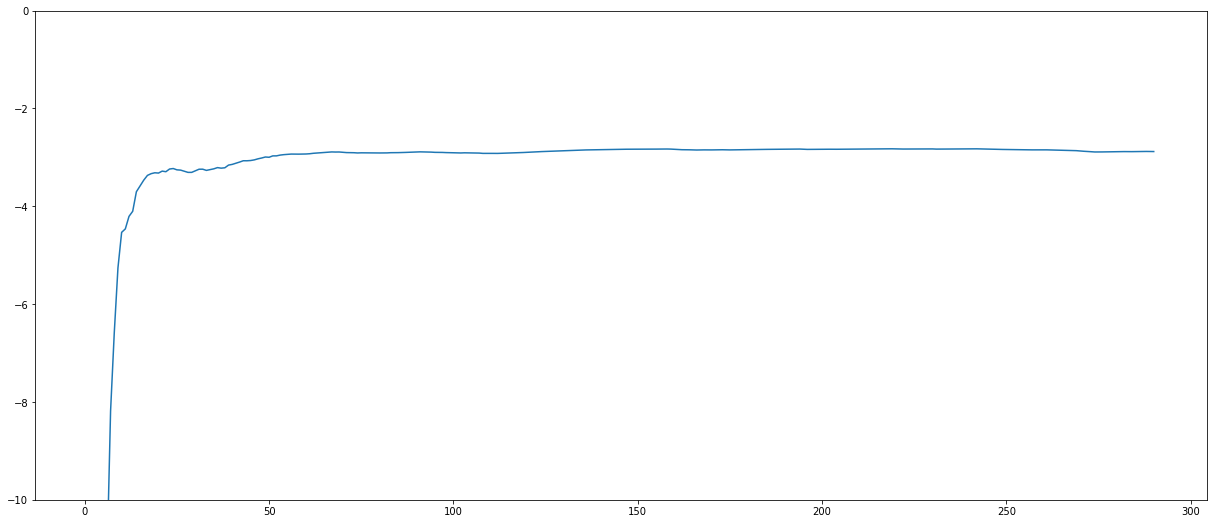

In [32]:
plt.figure(figsize=(21,9))
plt.plot(range(291),log_lik_ksgld)
plt.ylim(-10,0)

[]

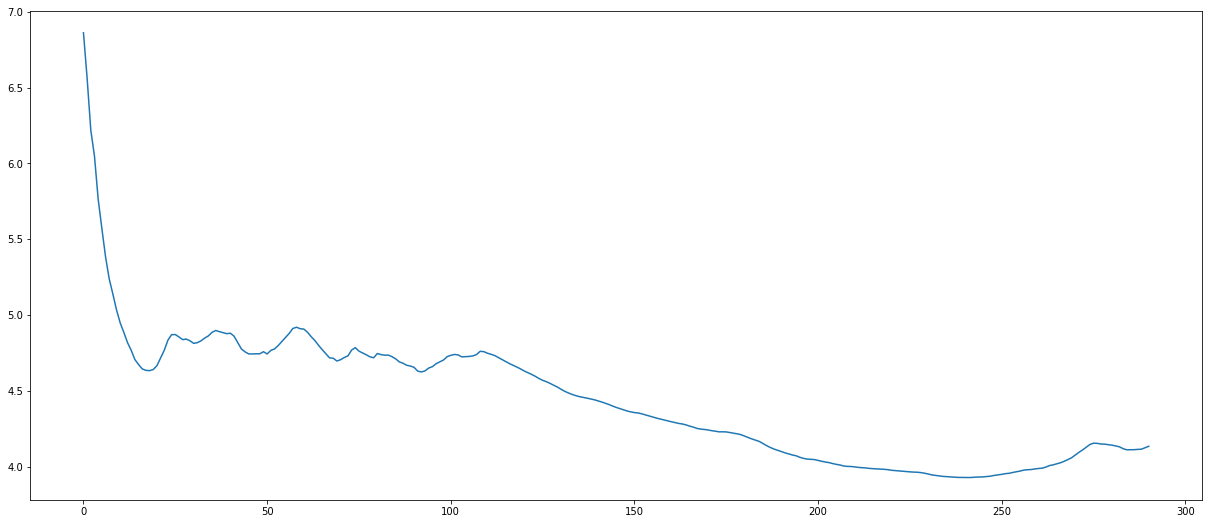

In [35]:
plt.figure(figsize=(21,9))
plt.plot(range(291),test_rmse)
plt.plot()

# Simulated Datasets

## Cubic

20 data points simulated as follows:

- x sampled from $\mathcal{U}(-4,4)$
- y sampled from $\mathcal{N}(x^3,3^2)$

In [ ]:
x, _ = torch.empty(20,1).uniform_(-4,4).sort(0)
y = torch.normal(x**3,3)
grid = np.linspace(-6,6,400).reshape(-1,1)
y_true = grid ** 3

In [ ]:
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid,y_true)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(1, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgd

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-4


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=False)

optim = sgd.optim.sgd(network, lr, lambda_, dataset_size)


#test_rmse = []
#log_lik_sgld = []


x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(20000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    
with torch.autograd.no_grad():
    prediction_sgd = network(x_test)

In [ ]:
plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(prediction_sgd.detach().numpy(),1),'black')
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')



### SGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-3
lr = 1e-3


batch_size = 20
dataset_size = 20

network = Model()
criterion = nn.MSELoss(size_average=True)

# optim = sgld.optim.sgld(network, lr, lambda_, dataset_size)
optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)

losses_sgld = []
#test_rmse = []
#log_lik_sgld = []
predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = (1/(2*9)) * criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions = torch.cat((predictions, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions[:,1:].detach().numpy(),1) + 3 * np.std(predictions[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions[:,1:].detach().numpy(),1) - 3 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)

### pSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-3
lr = 2e-4
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)


predictions_psgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0

    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_psgld = torch.cat((predictions_psgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)

### KSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-4, l2=1e-3, invert_every=1)


predictions_ksgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)



### KSGFS

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=0.01, l2=1e-3, invert_every=1)


predictions_ksgfs = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgfs = torch.cat((predictions_ksgfs, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgfs[:,1:].detach().numpy(),1), 'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-60,60)



In [ ]:
predictions_ksgfs[:,1:].size()

## Sinus (Louizos, Welling (2016))

20 data points simulated as follows:
- 12 samples $x_i$ from $\mathcal{U}(0,0.6)$ and 8 samples from $\mathcal{U}(0.8,1)$
- $y = x_i + \epsilon_i + \sin(4(x_i + \epsilon_i)) + \sin(13(x_i + \epsilon_i))$ with $\epsilon_i \sim \mathcal{N}(0,0.0009)$

See https://arxiv.org/pdf/1603.04733.pdf

In [ ]:
import math
# Create simulated data set
x1 = torch.empty(12, 1).uniform_(0, 0.6)
x2 = torch.empty(8, 1).uniform_(0.8, 1)

x,_ = torch.cat((x1,x2),0).sort(0)

epsilon = torch.normal(torch.zeros_like(x),math.sqrt(0.0009))
y = x + epsilon + torch.sin(4*(x + epsilon)) + torch.sin(13 * (x + epsilon))

grid = np.linspace(-1,2,400)
y_true = grid + np.sin(4 * grid) + np.sin(13 * grid)

In [ ]:
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid, y_true)

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgd




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-6
lr = 1e-1


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgd.optim.sgd(network, lr, lambda_, dataset_size)

#test_rmse = []
#log_lik_sgld = []
# predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    
with torch.autograd.no_grad():
    prediction_sgd = network(x_test)

In [ ]:
plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(prediction_sgd.detach().numpy(),1), 'black')
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')


### SGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-4


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgld.optim.sgld(network, lr, lambda_, batch_size ,dataset_size)

losses_sgld = []
#test_rmse = []
#log_lik_sgld = []
predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions = torch.cat((predictions, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r',alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)



### pSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 3e-12
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)


predictions_psgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0

    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_psgld = torch.cat((predictions_psgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)


### KSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-14, l2=1e-3, invert_every=1)


predictions_ksgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1. / (2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)



### KSGFS

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-1, l2=1e-3, invert_every=1)


predictions_sgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1. / (2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_sgld = torch.cat((predictions_sgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) + np.std(predictions_sgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_sgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) - np.std(predictions_sgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_sgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_sgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)

